In [1]:
import pandas as pd
from importlib import reload
from config import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import helpers as hp
# reload(hp)
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import pickle

# Loading dataset

Data types will be cast to the most appropriate types, to reduce memory usage.

In [2]:
df = pd.read_csv(DF_TRAIN_FILE_PATH, 
                 dtype=DATA_CAST_DICT, index_col=INDEX
)
df.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
UniqueID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


In [4]:
df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=df[LABEL])
df_orig = df.copy()
df = df_train

Data exploring will be done using training data, however every transformation will be extracted into function and in transformer class (compatible with sklearns transfomers), located in helpers.py.

In [5]:
rows, cols = df.shape

print("Dataset shape")
print(20*'-')
print(f"No of rows: {rows}\nNo of cols: {cols}")
print(20*'-')

Dataset shape
--------------------
No of rows: 209838
No of cols: 40
--------------------


In [6]:
df[LABEL].value_counts(normalize=True) * 100

0    78.292778
1    21.707222
Name: loan_default, dtype: float64

We are dealing with skewed dataset. <i>Label 0</i> (didn't returned loan) takes roughly <b>78%</b> and <i>label 1</i> (returned loan) <b>21%</b>. That means we shall NOT consider <i>accuracy</i> as our main metric when modelling.

In [7]:
df.isna().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        6888
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS               

Only one attribute has NaNs, so the process of fixing NaNs will be relativelly easy.

# Dataset analysis

## Data types

In [8]:
# Rename column names for consistency
df.rename(columns={"PRIMARY.INSTAL.AMT": "PRI.INSTAL.AMOUNT",
                    "SEC.INSTAL.AMT": "SEC.INSTAL.AMOUNT"}, inplace=True)

# Replace dots in column names with underscore
df.columns = [a.replace(".", "_") for a in df.columns]

# Fix date formats for 'Date_of_Birth' 
# For example, year 18 should be treated as 2018, year 63 as 1963 and so on.
def fix_date(date: str) -> int:
    day, month, year = date.split('-')
    year = int(year)
    
    # 2019 was the year dataset was aquired
    if 0 <= year <= 19:
        year_fixed = year + 2000
    else:
        year_fixed = year + 1900

    date_fixed = '-'.join([day, month, str(year_fixed)])
    return date_fixed

# Fixing date format for columns 'Date_of_Birth', 'DisbursalDate' and converting them to datetime
df['Date_of_Birth'] = pd.to_datetime(df['Date_of_Birth'].apply(fix_date), format="%d-%m-%Y")
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'].apply(fix_date), format="%d-%m-%Y")

# Fix duration format for columns 'AVERAGE_ACCT_AGE' & 'CREDIT_HISTORY_LENGTH'
def duration(dur: str) -> int:
    years = int(dur.split(' ')[0].replace('yrs',''))
    months = int(dur.split(' ')[1].replace('mon',''))
    
    # Returns duration in months
    return months + 12 * years

df['AVERAGE_ACCT_AGE'] = df['AVERAGE_ACCT_AGE'].apply(duration).astype('uint16')
df['CREDIT_HISTORY_LENGTH'] = df['CREDIT_HISTORY_LENGTH'].apply(duration).astype('uint16')

# Calculate age of loanee using its date of birth
df['Age'] = ((pd.Timestamp(2019, 1, 1) - df['Date_of_Birth']) / np.timedelta64(1, 'Y'))

# Define numerical, nominal and ordinal column names
numerical = ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS_SCORE', 
             'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
             'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
             'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
             'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
             'SEC_DISBURSED_AMOUNT', 'PRI_INSTAL_AMOUNT', 'SEC_INSTAL_AMOUNT',
             'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
             'NO_OF_INQUIRIES', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'Age'
]
ordinal = ['Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag']

nominal = ['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
'Employment_Type', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag', 'PERFORM_CNS_SCORE_DESCRIPTION',
]

other = ['Date_of_Birth', 'DisbursalDate']

derived_numerical = []
derived_ordinal = []
derived_nominal = []

# Numeric features

In following cells every column is going to be inspected: its values, distribution (if numeric), unusual values... If there are unknown or NaNs, they will be taken care of.
<br>
<br>
As we go columns will be added to their appropriate lists (numeric, ordinal, nominal, deletion) for keeping track of progress more easily.
<br>
<br>
2  more datesets will be made: one which has logarithm function applied on numerical columns and second that has its outliers replaced using boxplot and clipping. These two datasets will be of use for visual inspection of feature distributions and boxplots.

In [9]:
df_no_outliers = hp.NumericColumnsTransformer(method='outlier_replacement').fit_transform(df, columns=numerical)
df_logged = hp.NumericColumnsTransformer(method='log').fit_transform(df, columns=numerical)

df_names = ["df", "df_no_outliers", "df_logged"]

df


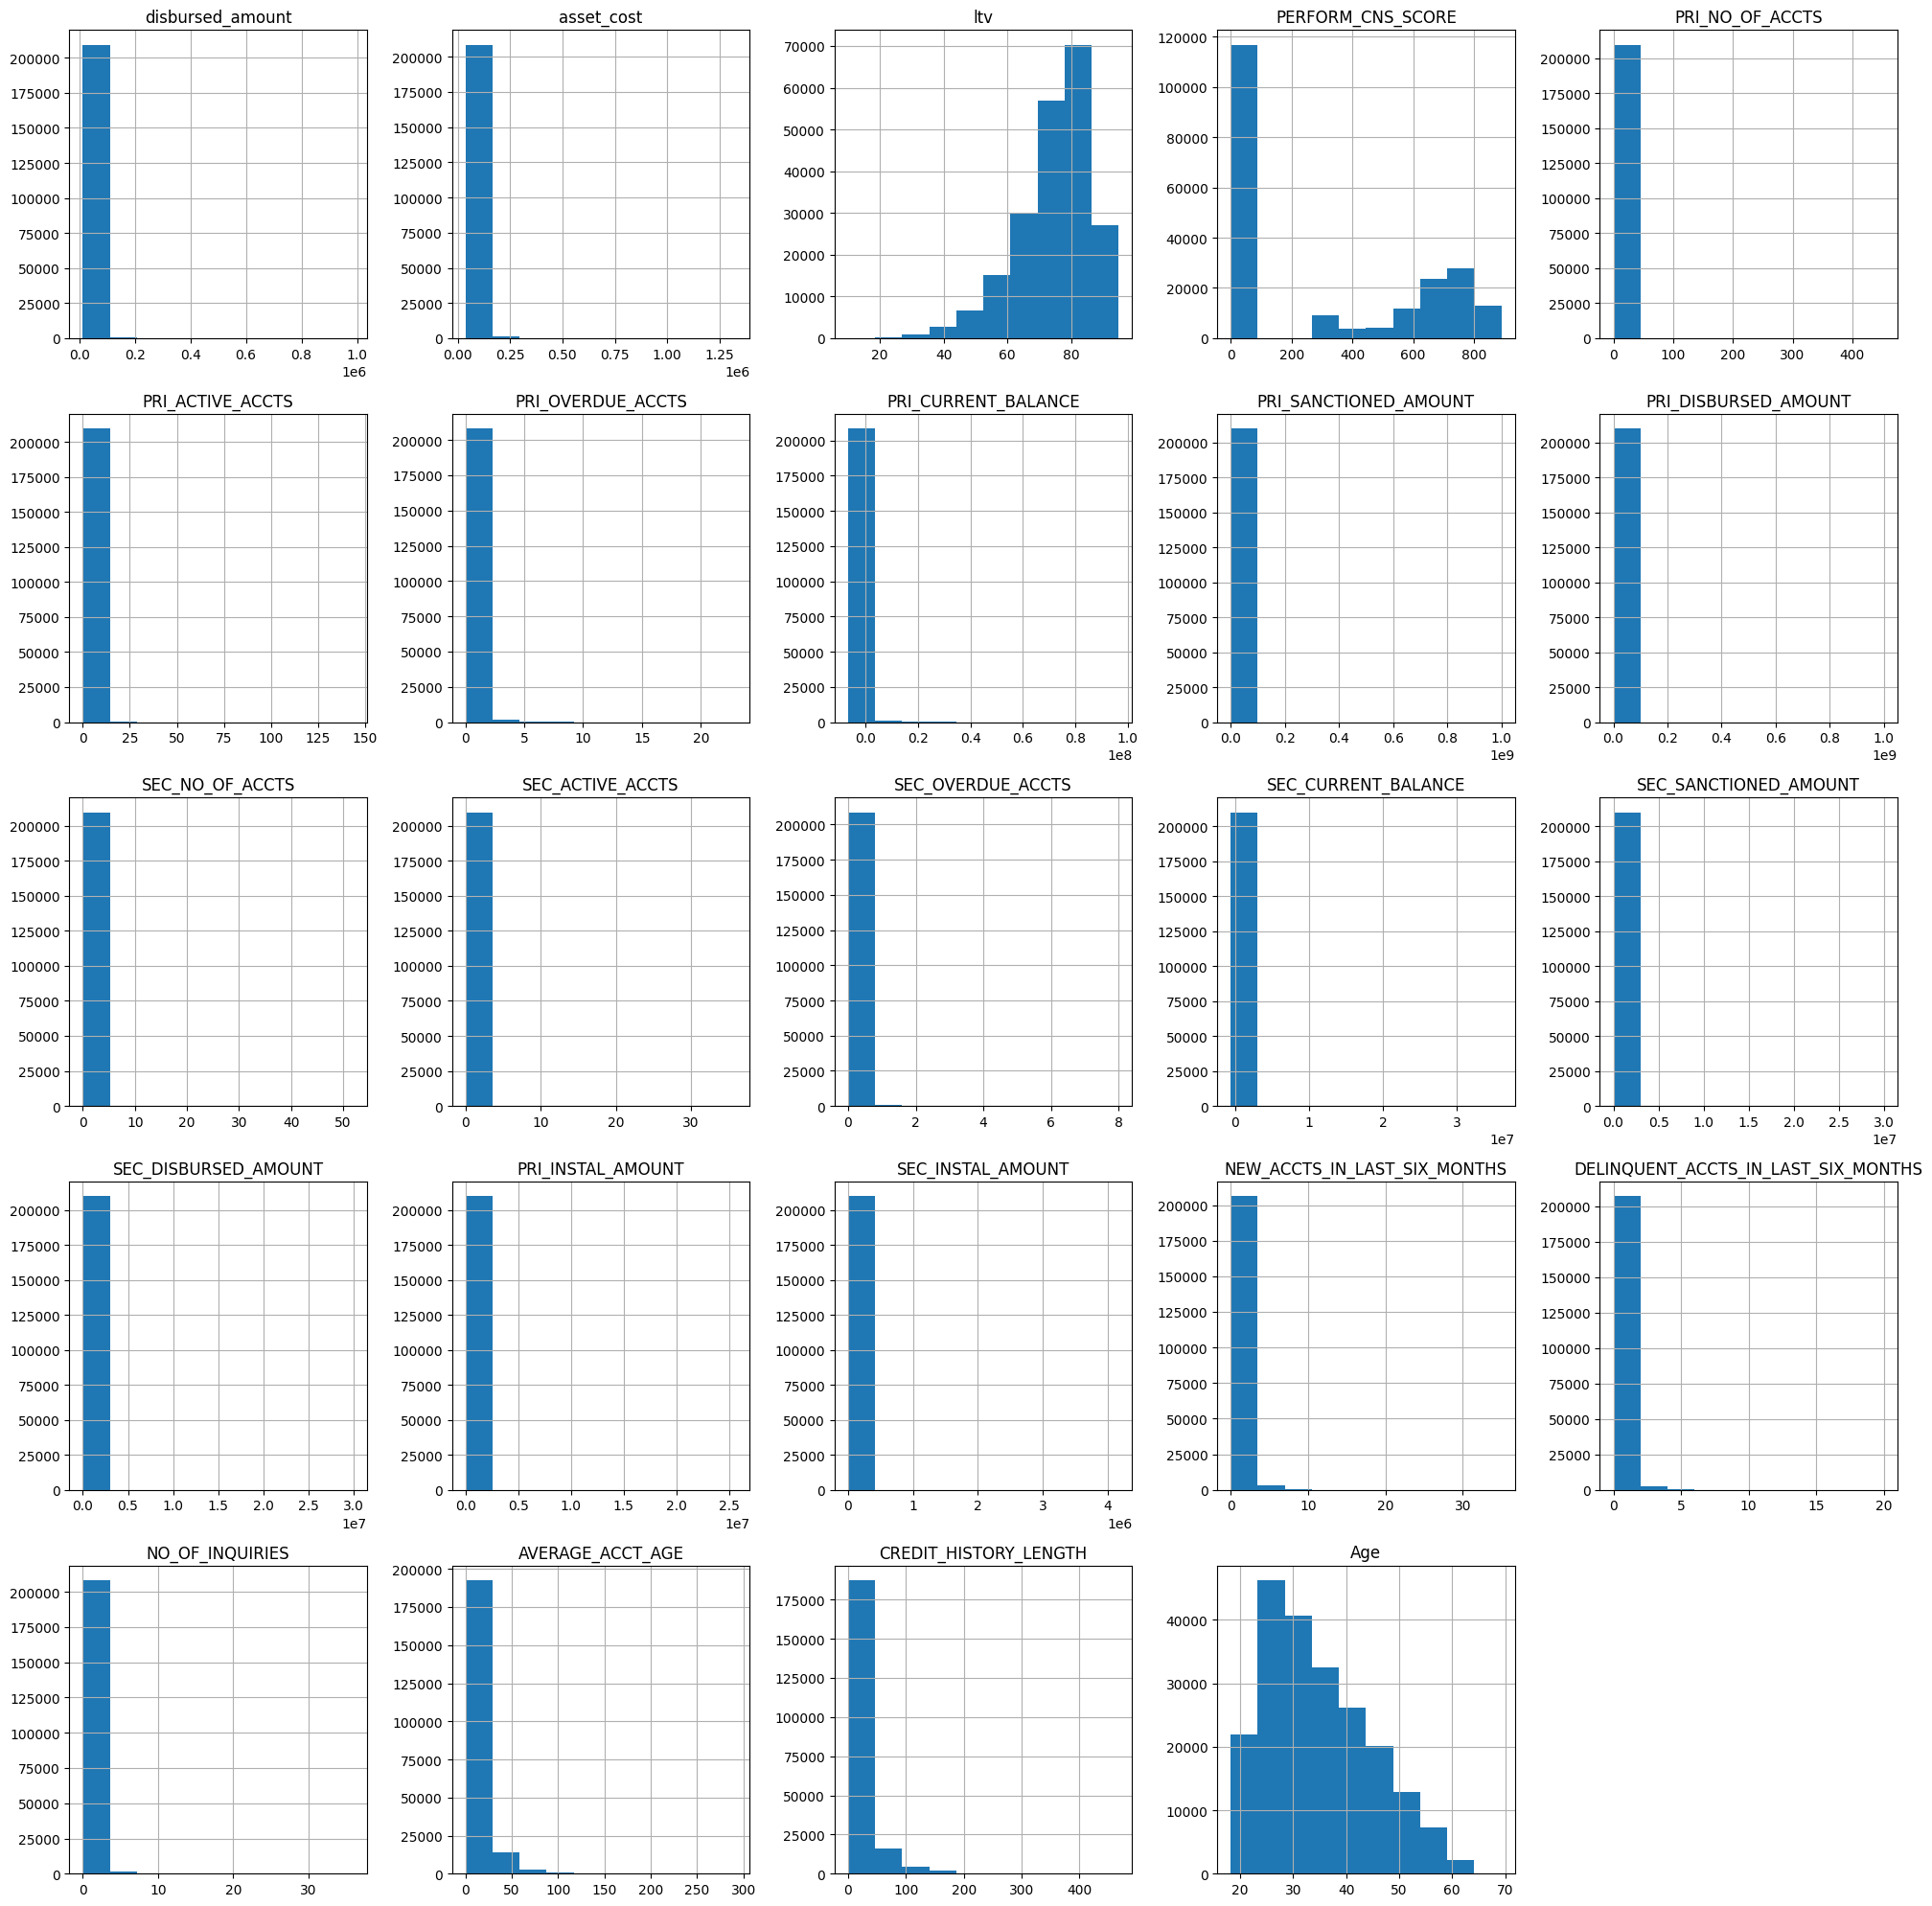

df_no_outliers


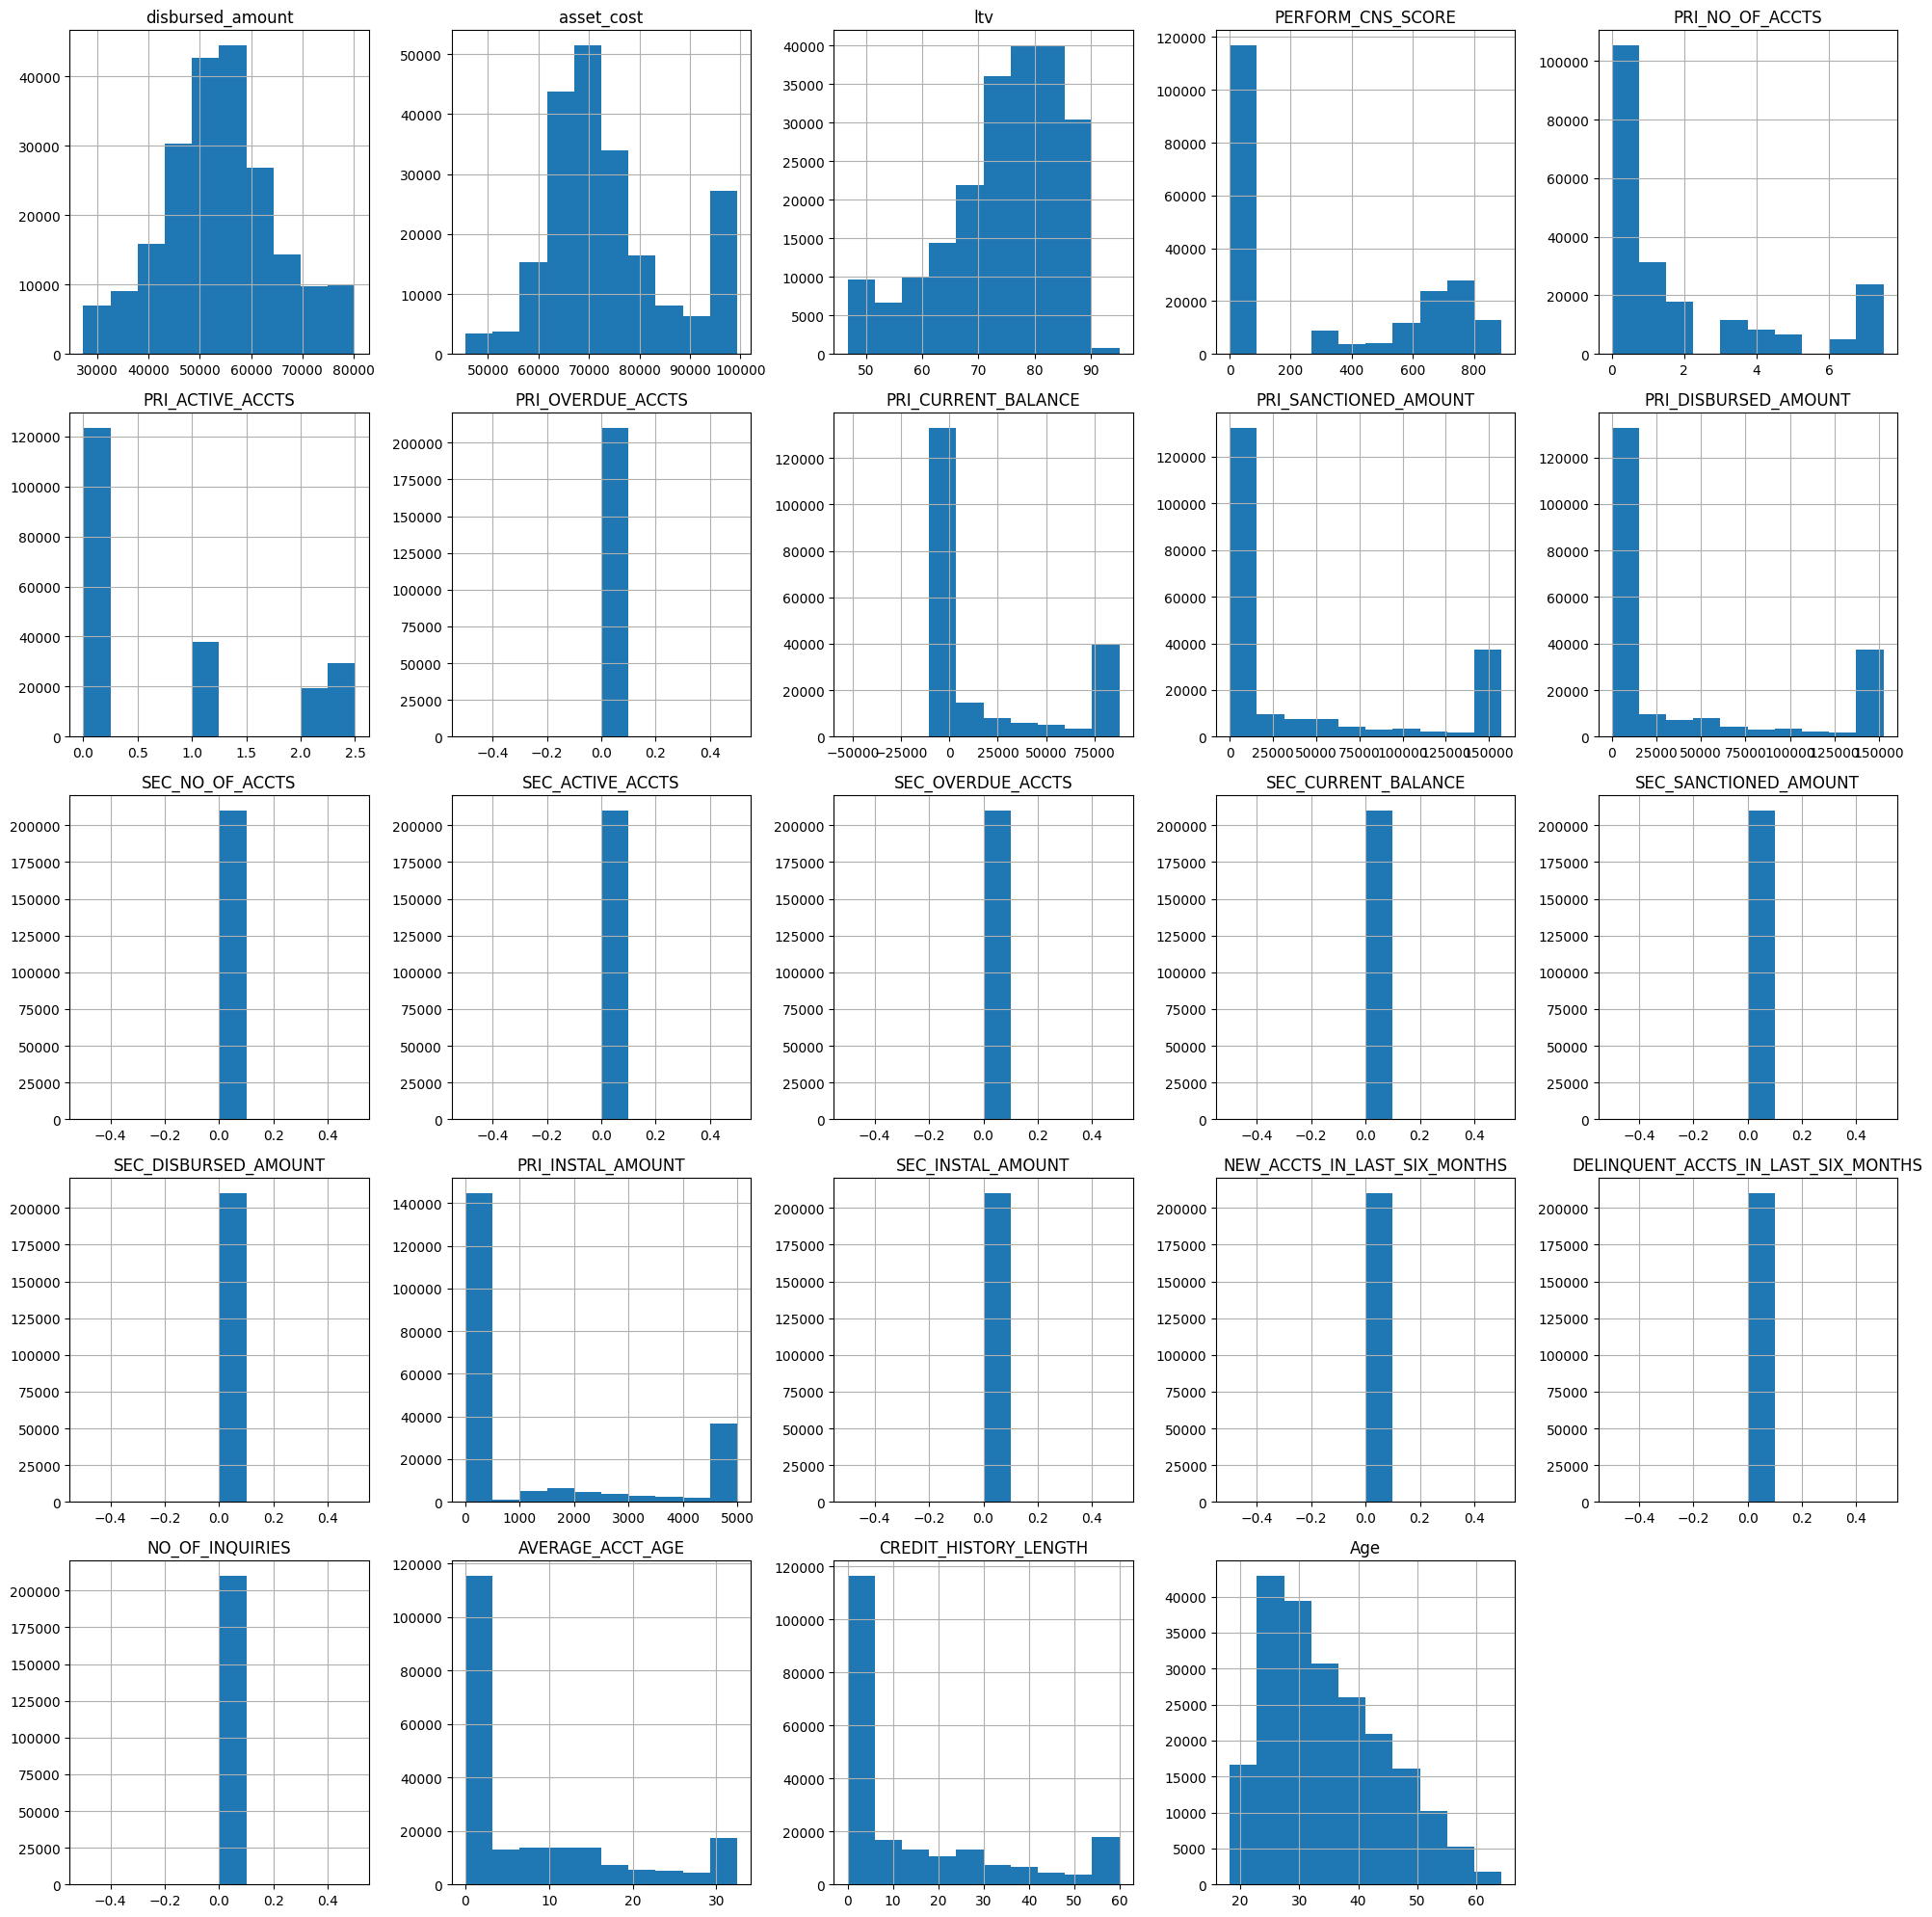

df_logged


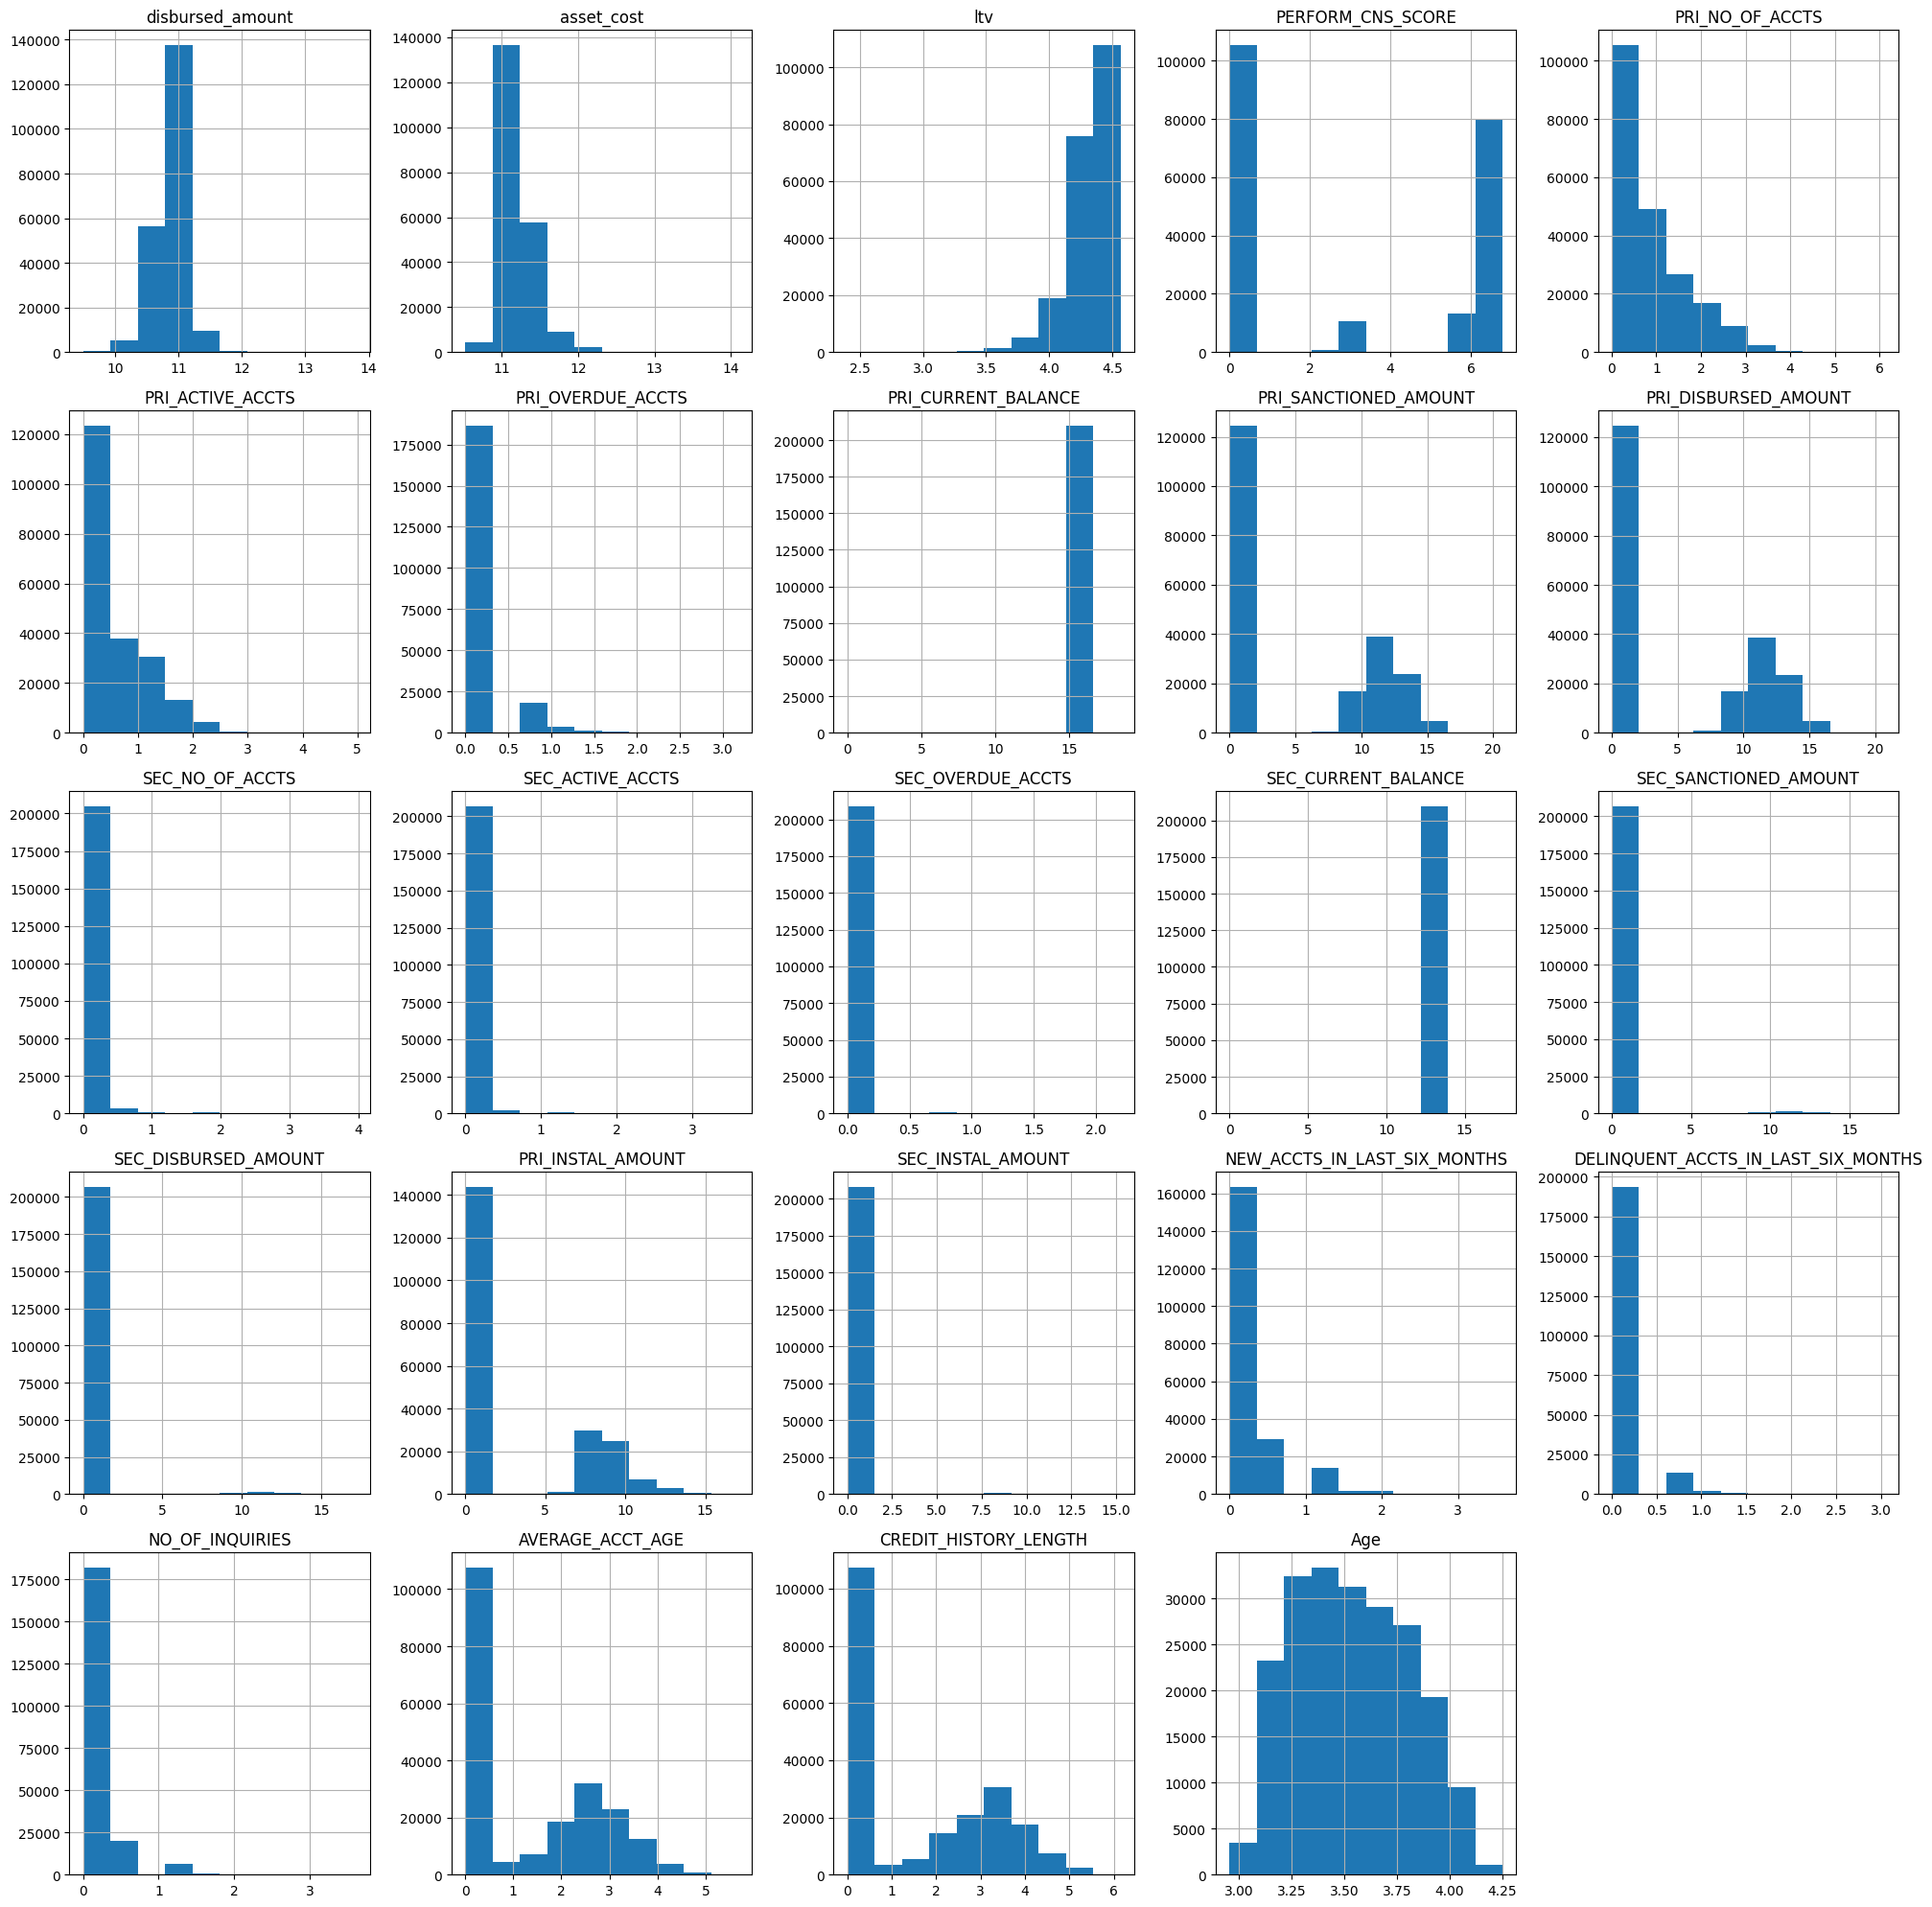

In [10]:
# Display histograms
for df_name in df_names:
    print(f"{df_name}")
    df_ = globals()[f'{df_name}']
    df_.hist(column=numerical, figsize=(20, 20), layout=(5, 5))
    plt.tight_layout()
    # plt.savefig(f"data/images/{df_name}_hist.png")
    plt.show();

df


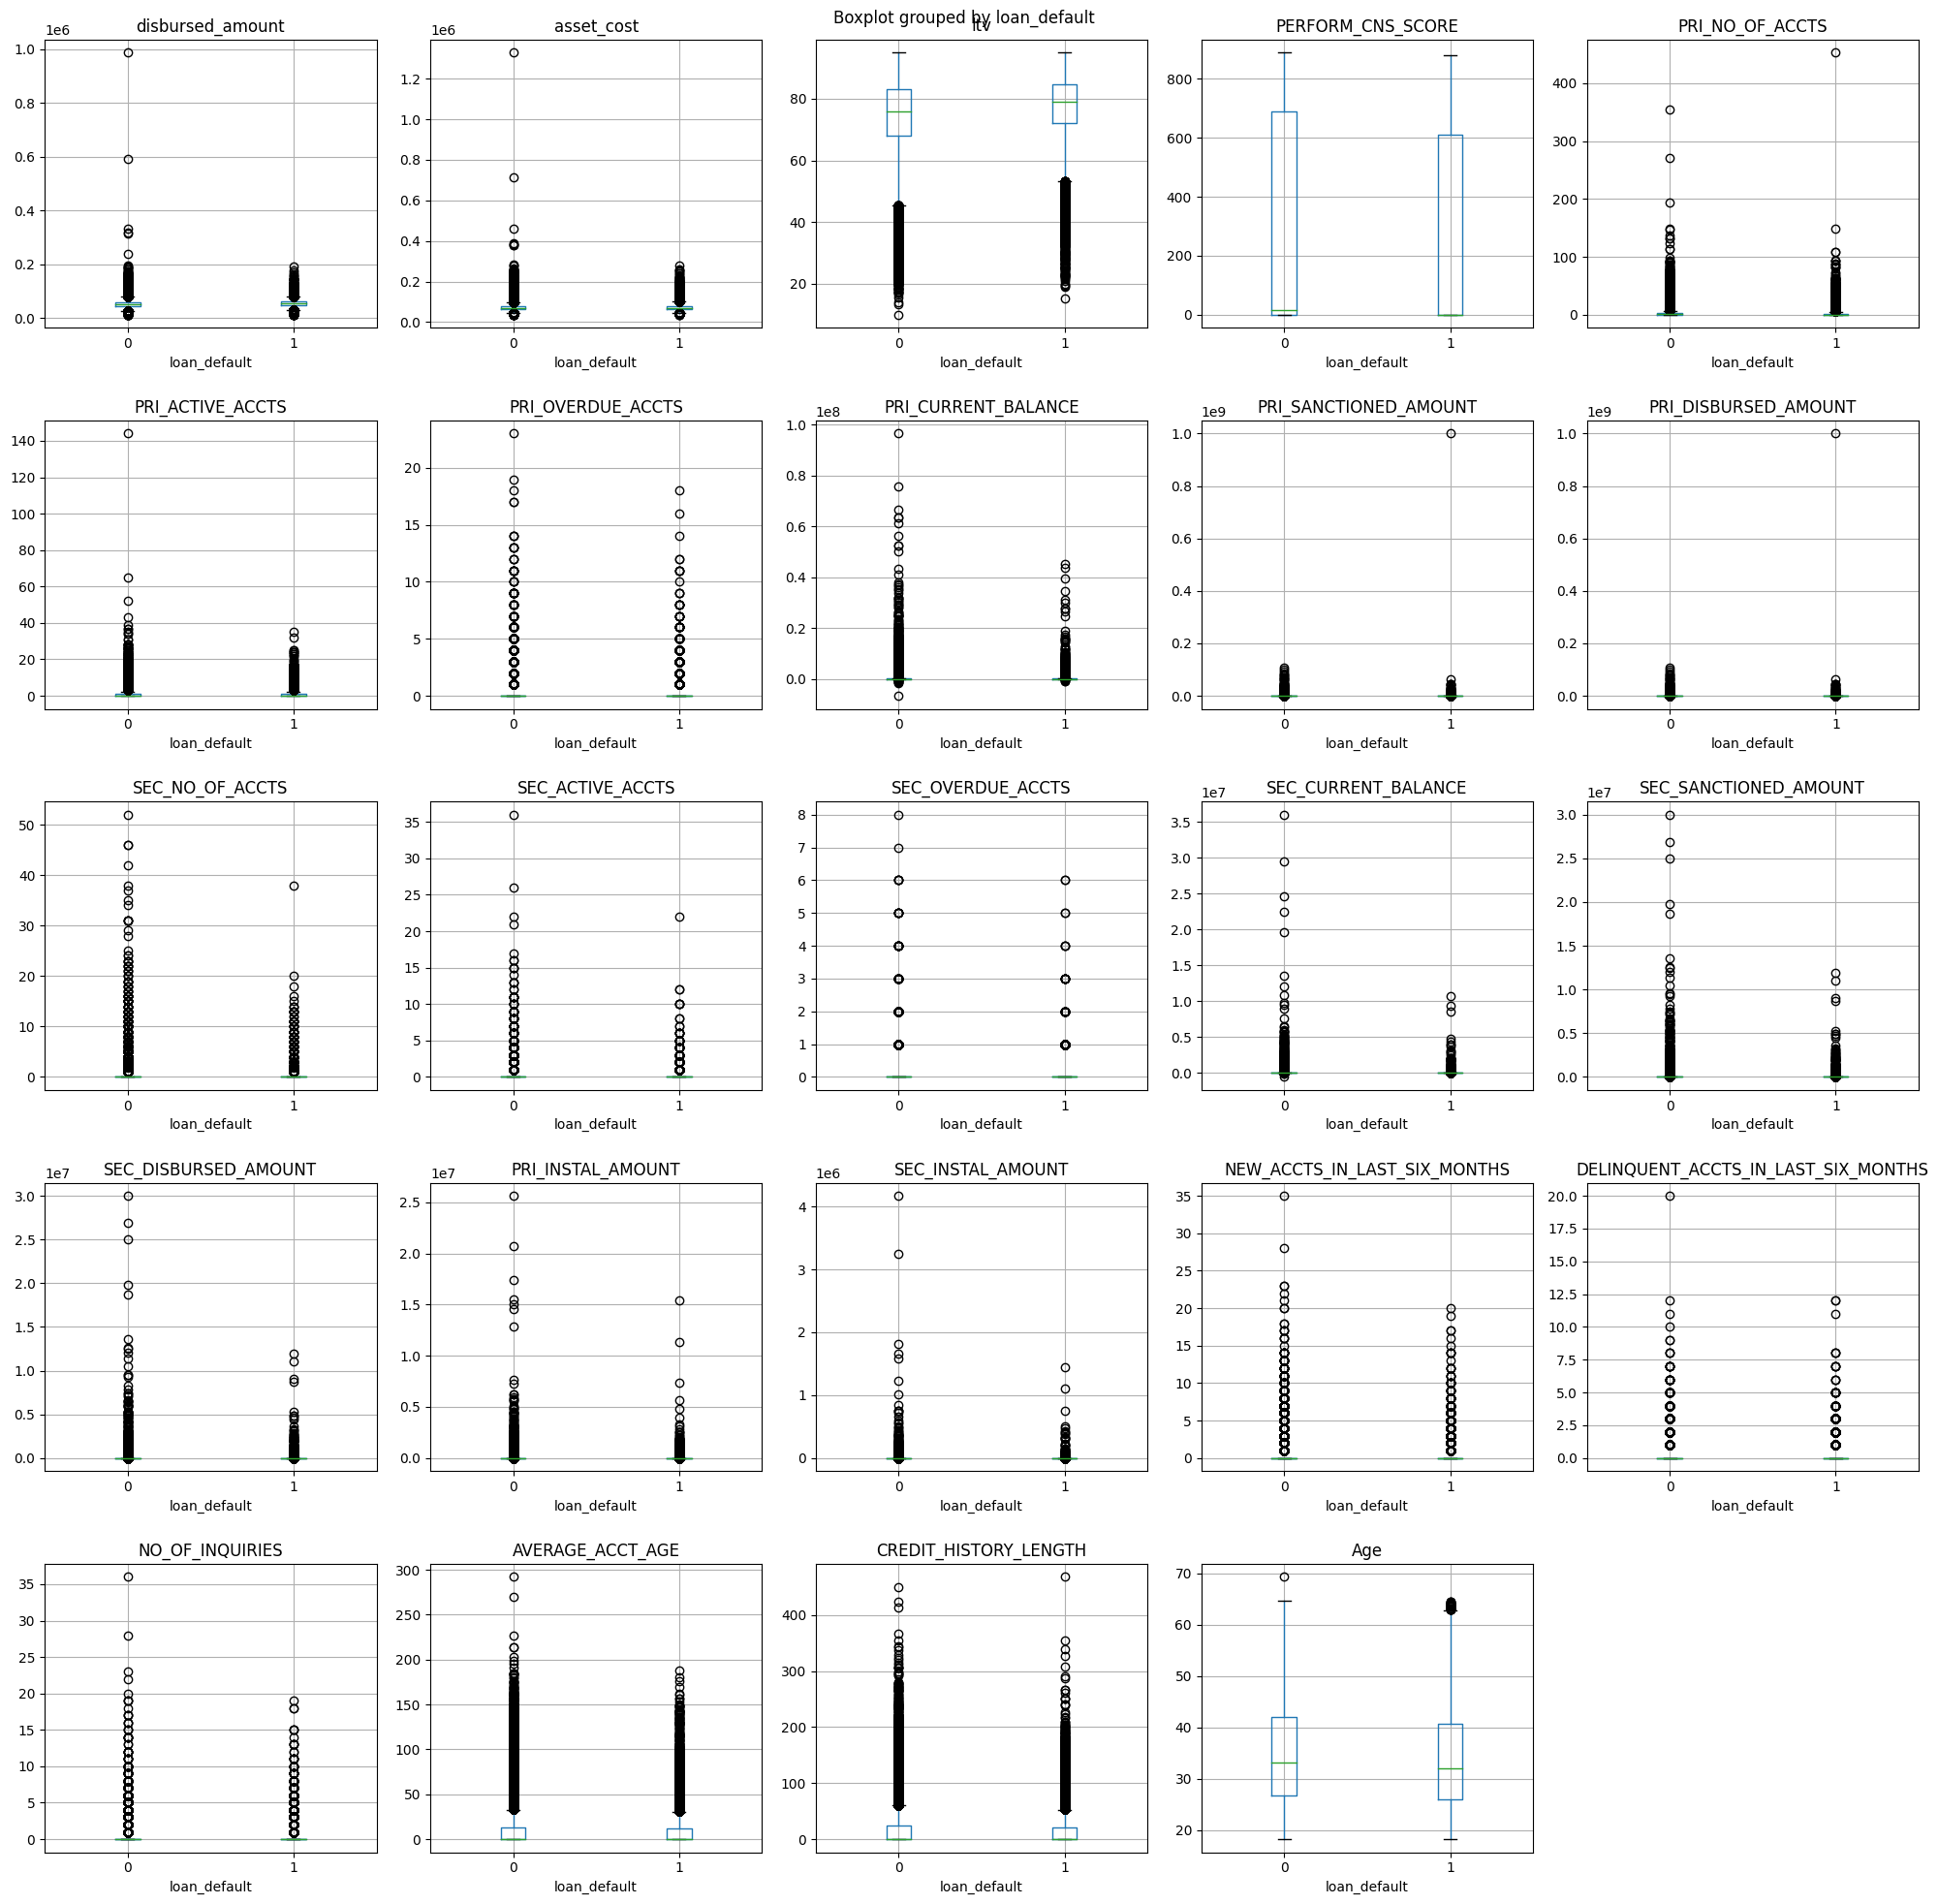

df_no_outliers


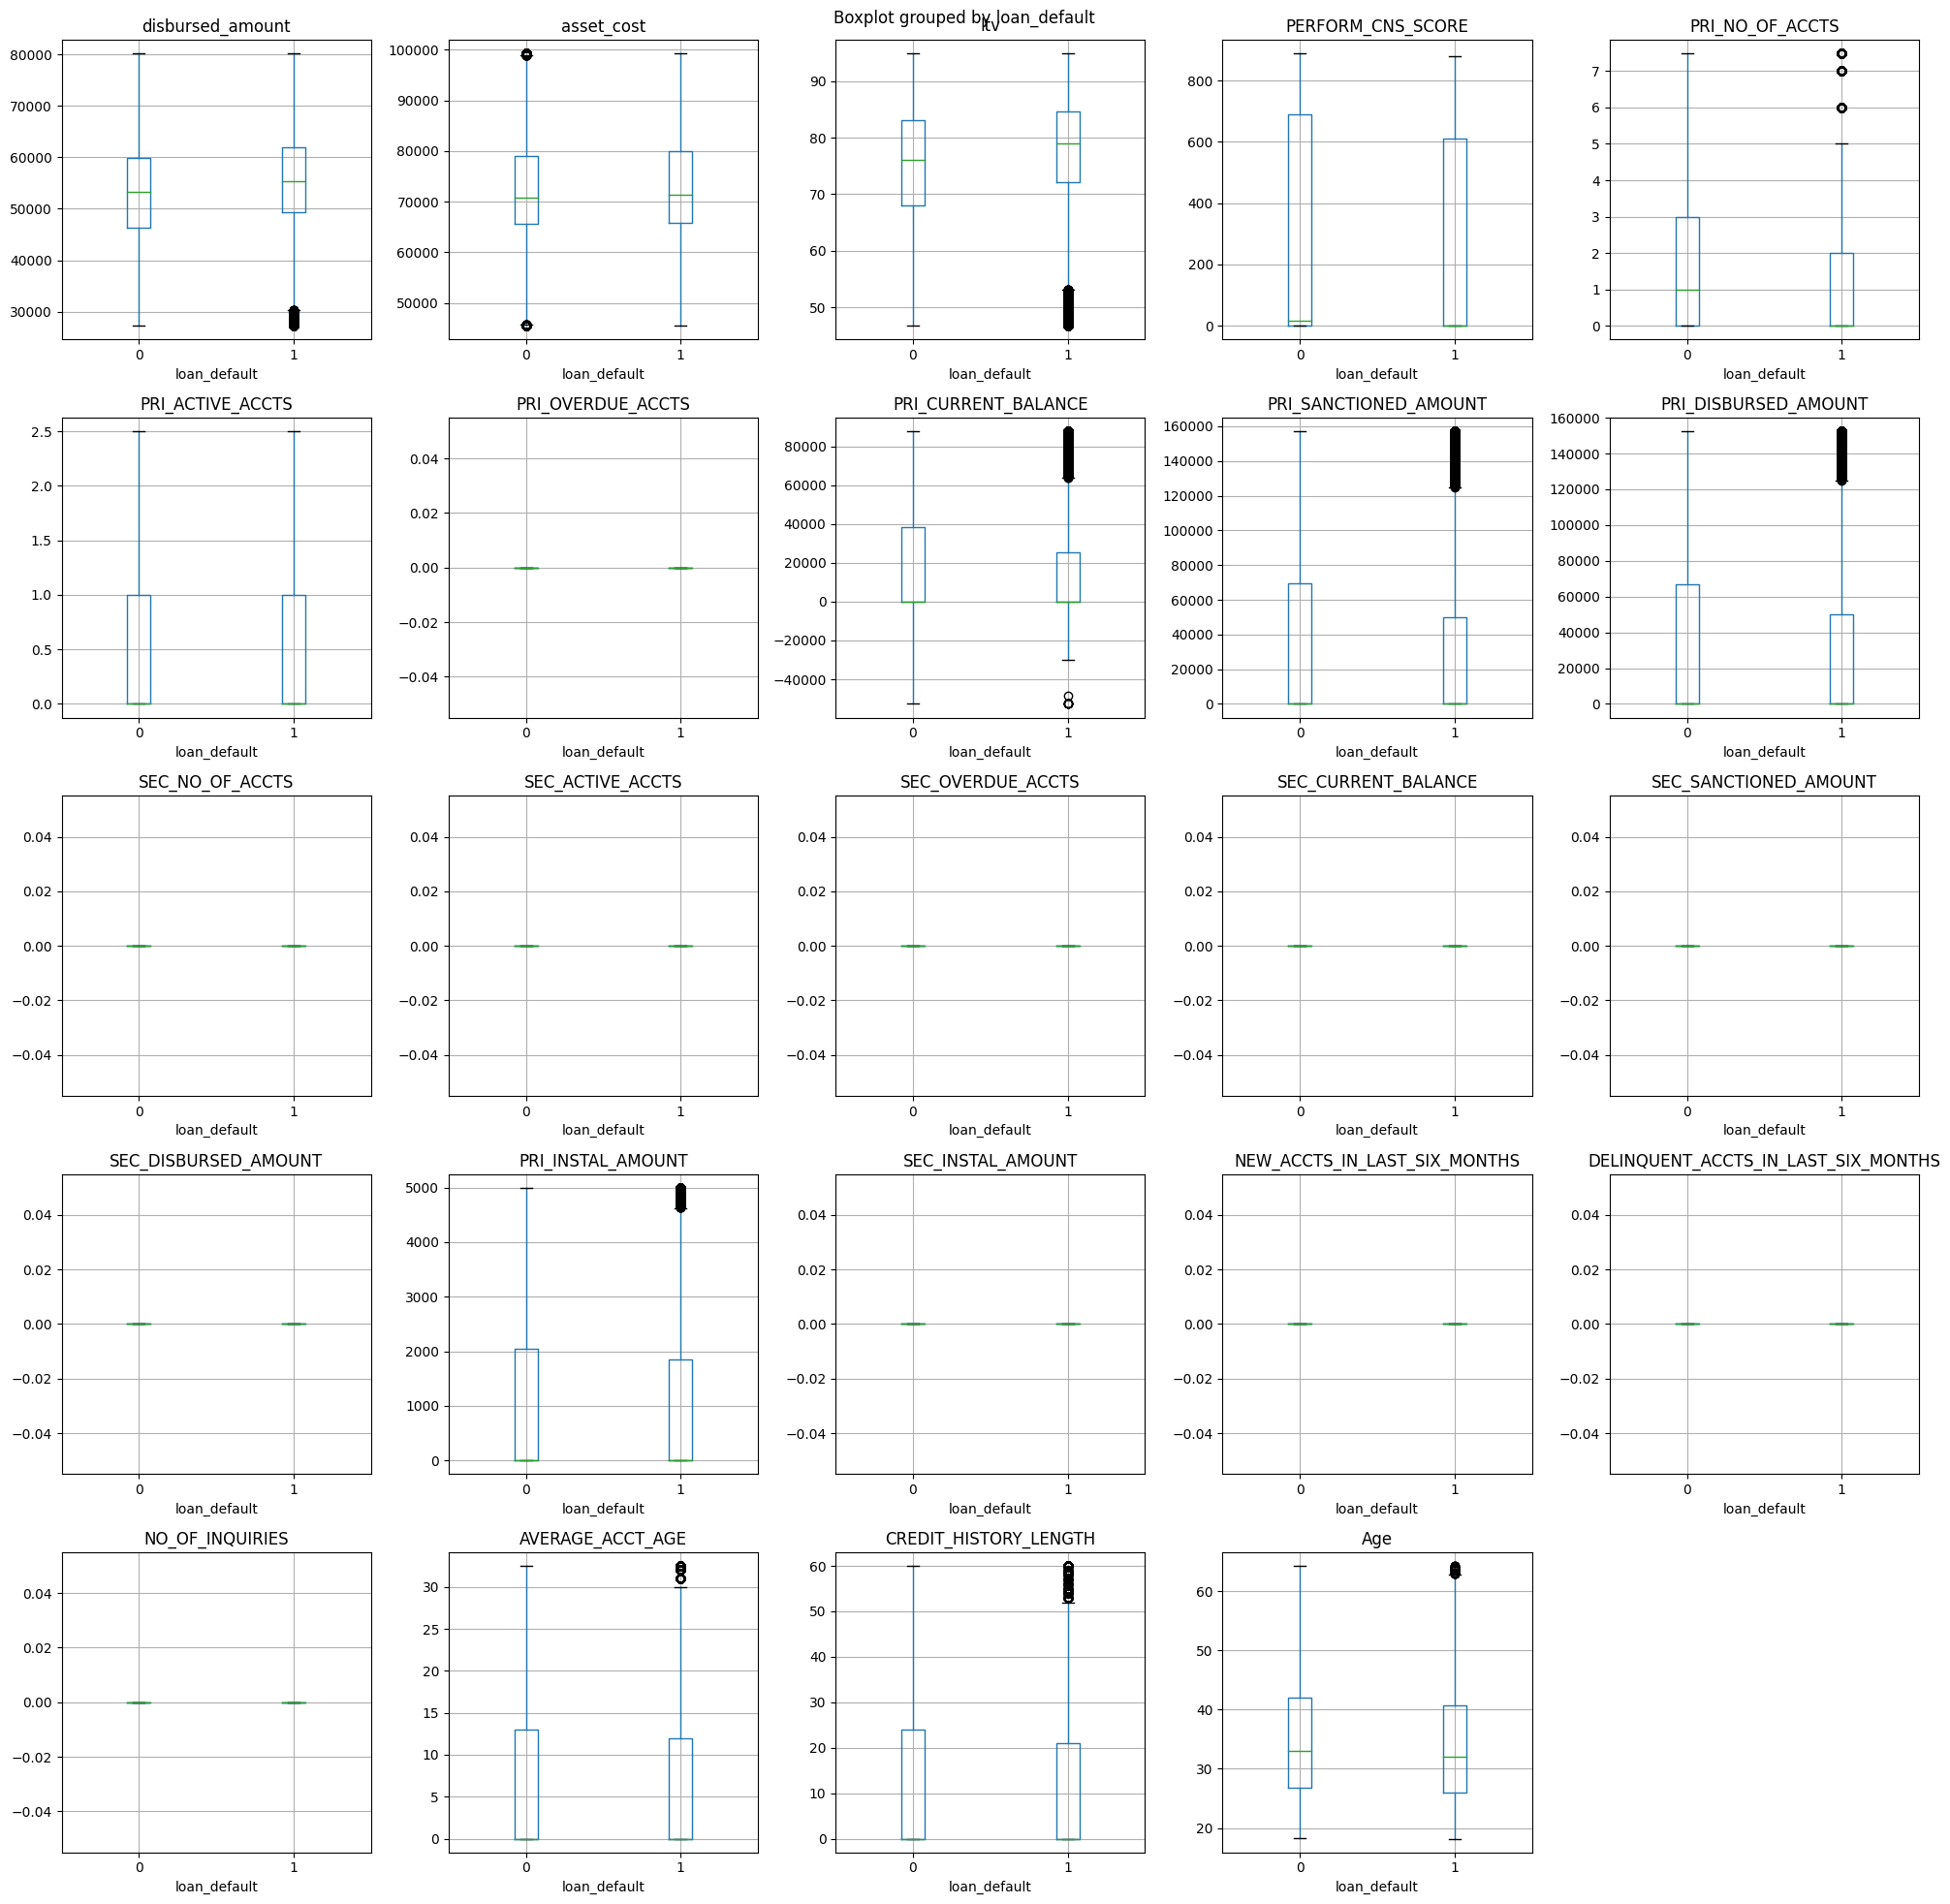

df_logged


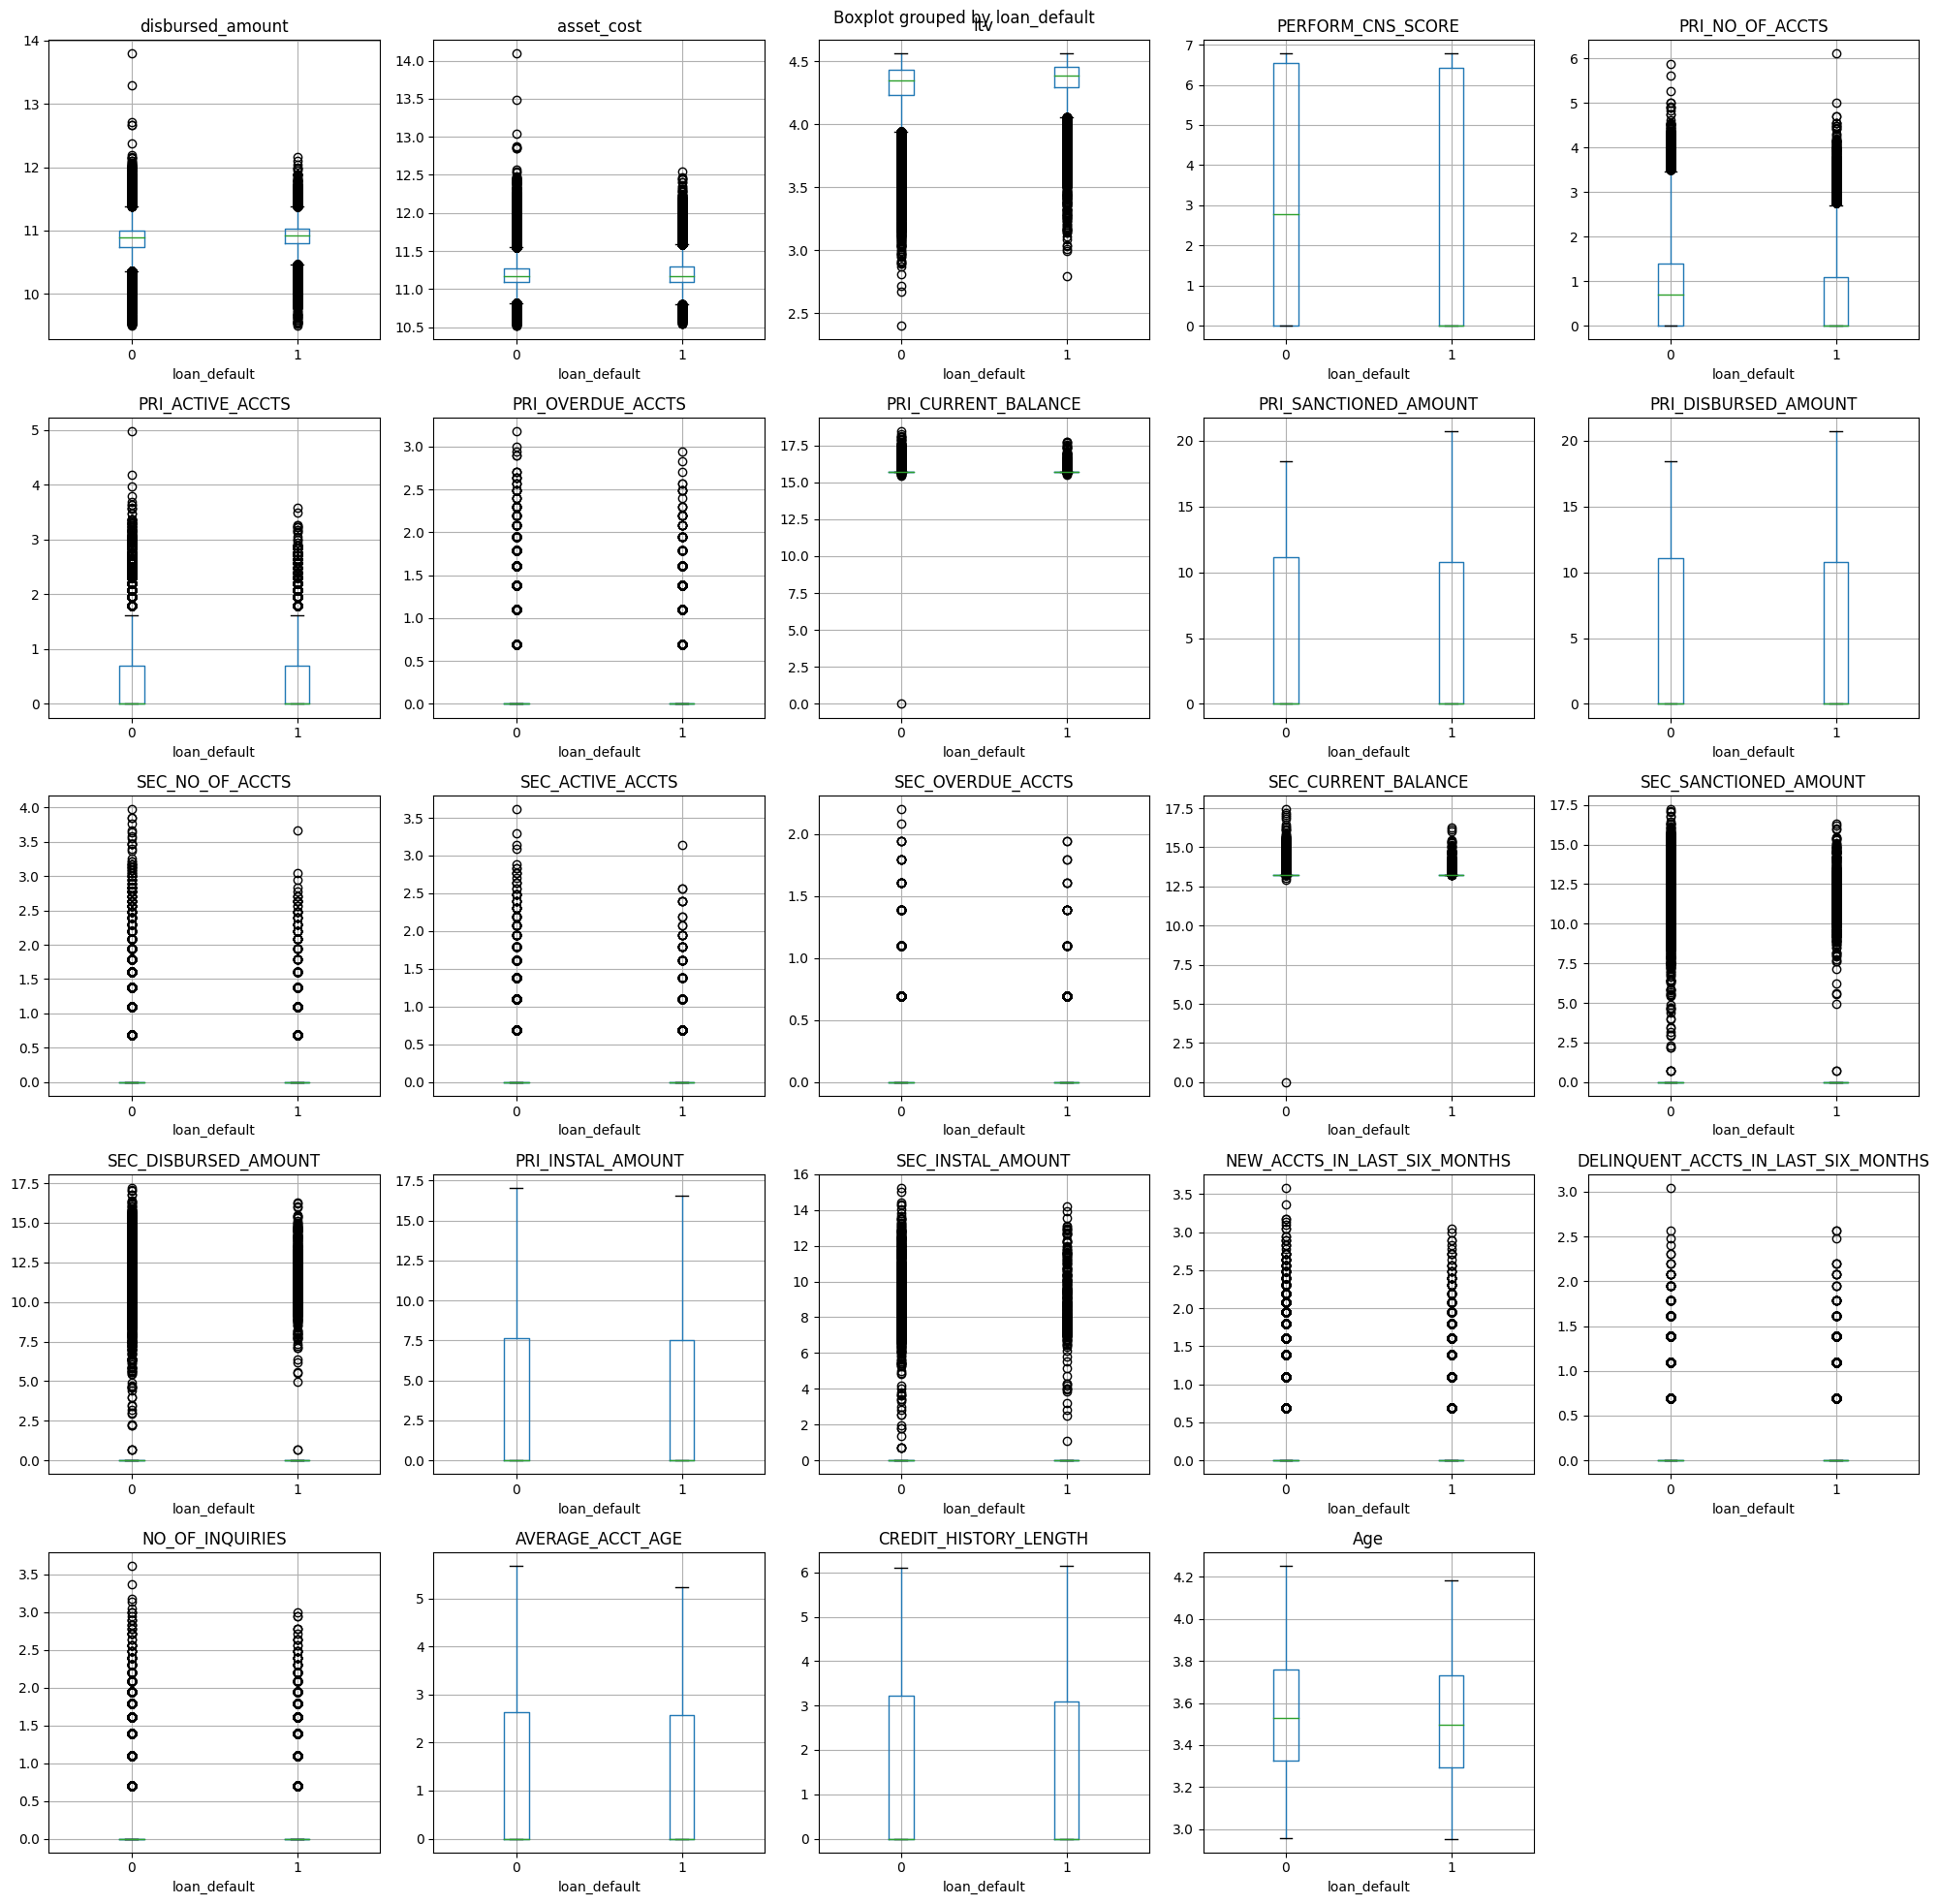

In [11]:
# Display boxplots
for df_name in df_names:  
    print(f"{df_name}")
    df_ = globals()[f'{df_name}']
    df_.boxplot(column=numerical, figsize=(20, 20), by=LABEL, layout=(5,5), sharey=False, sharex=False)
    plt.tight_layout()
    # plt.savefig(f"data/images/{df_name}_box.png")
    plt.show();

In [12]:
del df_no_outliers, df_logged

In [13]:
df[numerical].describe()

,disbursed_amount,asset_cost,ltv,PERFORM_CNS_SCORE,PRI_NO_OF_ACCTS,PRI_ACTIVE_ACCTS,PRI_OVERDUE_ACCTS,PRI_CURRENT_BALANCE,PRI_SANCTIONED_AMOUNT,PRI_DISBURSED_AMOUNT,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRI_INSTAL_AMOUNT,SEC_INSTAL_AMOUNT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,Age
count,209838.000000,2.098380e+05,209838.000000,209838.000000,209838.000000,209838.000000,209838.000000,2.098380e+05,2.098380e+05,2.098380e+05,...,2.098380e+05,2.098380e+05,2.098380e+05,2.098380e+05,209838.000000,209838.000000,209838.000000,209838.000000,209838.000000,209838.000000
mean,54350.563659,7.584366e+04,74.756129,289.569287,2.437809,1.040541,0.156101,1.654890e+05,2.183854e+05,2.179875e+05,...,7.501814e+03,7.388099e+03,1.319829e+04,3.333539e+02,0.382562,0.097451,0.206945,8.919929,16.253334,34.752346
std,12853.438886,1.869096e+04,11.454483,338.391911,5.220377,1.942423,0.544221,9.344471e+05,2.470107e+06,2.473275e+06,...,1.888892e+05,1.883499e+05,1.552419e+05,1.623997e+04,0.955661,0.383693,0.704182,15.111447,28.568060,9.825287
min,13320.000000,3.700000e+04,10.030000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,18.198868
25%,47145.000000,6.570500e+04,68.900000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,26.623408
50%,53800.000000,7.093050e+04,76.810000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,32.999993
75%,60400.000000,7.915975e+04,83.670000,678.000000,3.000000,1.000000,0.000000,3.512200e+04,6.287250e+04,6.100000e+04,...,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,13.000000,24.000000,41.684634
max,987354.000000,1.328954e+06,95.000000,890.000000,453.000000,144.000000,23.000000,9.652492e+07,1.000000e+09,1.000000e+09,...,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,292.000000,468.000000,69.296426


In [14]:
pri_cols = [a for a in numerical if a.startswith("PRI_")]
sec_cols = [a for a in numerical if a.startswith("SEC_")]

'PERFORM_CNS_SCORE' will be processed later.
<br>
<br>
It's very unusal why there are people with negative current balance. abs() function will be applied onto the values.

In [15]:
# Some lonees had negative current balance, so applying absolute 
# value will make irregular values positive and thus valid
df['PRI_CURRENT_BALANCE'] = df['PRI_CURRENT_BALANCE'].abs()
df['SEC_CURRENT_BALANCE'] = df['SEC_CURRENT_BALANCE'].abs()

Let's see Pearson correlations for all numerical cols.

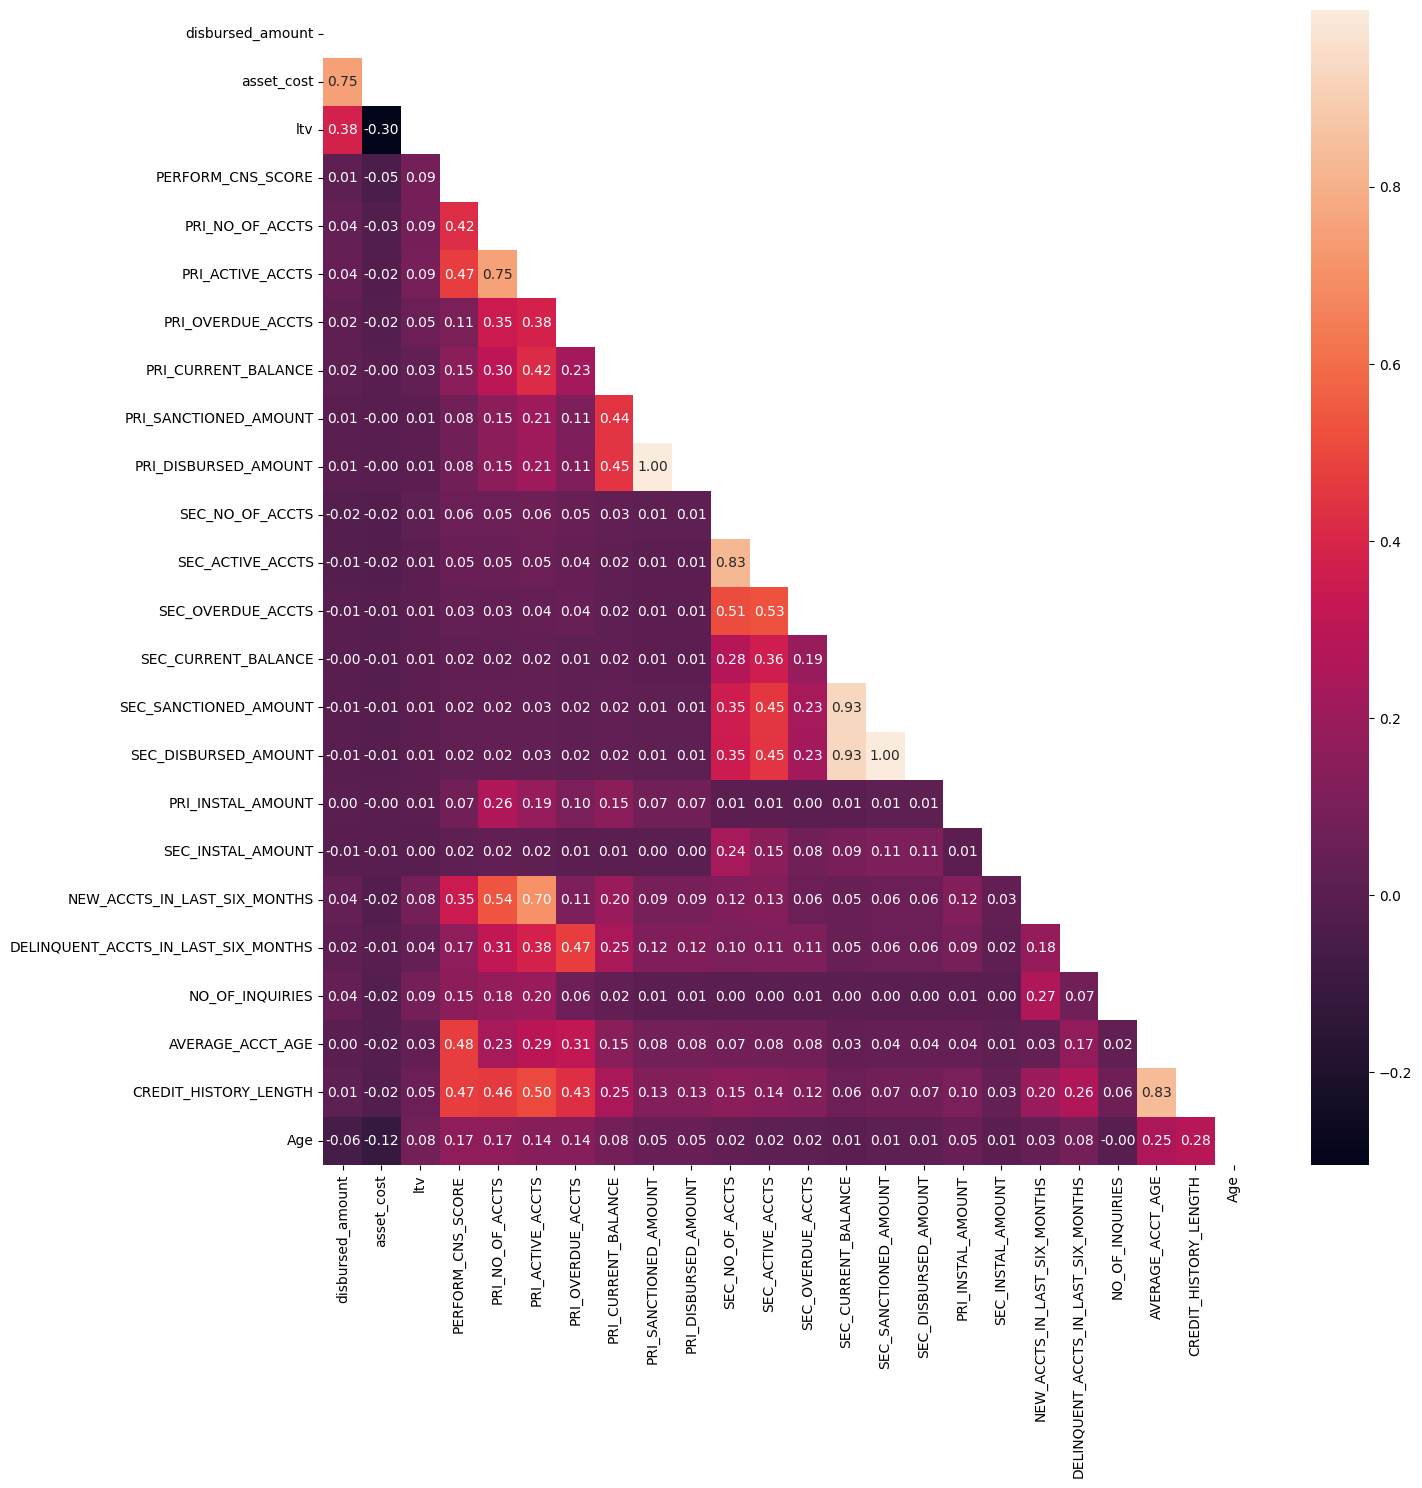

In [16]:
plt.figure(figsize=(15, 15))
corr = df[numerical].corr()

# Upper triangular heatmap of correlations with annotations
sns.heatmap(corr, annot=True, mask=np.triu(corr), fmt='.2f');

Let's investigate relationship between 'x_CURRENT_BALANCE' & 'x_SANCTIONED_AMOUNT'.

Pearson correlations:
PRI: 0.4430722862865804
SEC: 0.9289728289897751


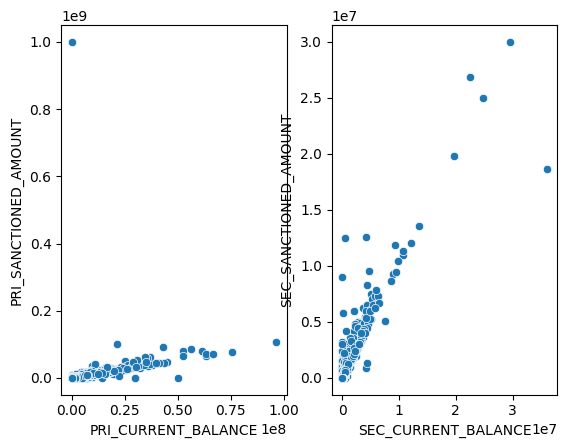

In [17]:
fig, axs = plt.subplots(1, 2)

sns.scatterplot(data=df, x='PRI_CURRENT_BALANCE', y='PRI_SANCTIONED_AMOUNT', ax=axs[0])
sns.scatterplot(data=df, x='SEC_CURRENT_BALANCE', y='SEC_SANCTIONED_AMOUNT', ax=axs[1])

print("Pearson correlations:")
print(f"PRI: {np.corrcoef(df['PRI_CURRENT_BALANCE'], df['PRI_SANCTIONED_AMOUNT'])[0][1]}")
print(f"SEC: {np.corrcoef(df['SEC_CURRENT_BALANCE'], df['SEC_SANCTIONED_AMOUNT'])[0][1]}")

It may seem strange that 'PRI_SANCTIONED_AMOUNT' & 'PRI_CURRENT_BALANCE' aren't much correlated, but the outlier in upper left corner is actually causing the misinformation.
<br>
<br>
After excluding the value temporarily, Pearson's correlation coefficient changed from 0.465 to 0.950.

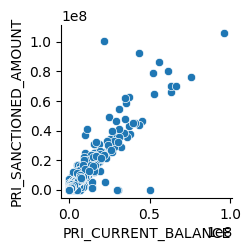

PRI_CURRENT_BALANCE correlation: 0.9467684303053405


In [18]:
temp_sanctioned = df['PRI_SANCTIONED_AMOUNT'] != df['PRI_SANCTIONED_AMOUNT'].max()

sns.pairplot(data=df.loc[temp_sanctioned, :], x_vars='PRI_CURRENT_BALANCE', y_vars='PRI_SANCTIONED_AMOUNT')
plt.show()

print(f"PRI_CURRENT_BALANCE correlation: {np.corrcoef(df.loc[temp_sanctioned, 'PRI_CURRENT_BALANCE'], df.loc[temp_sanctioned, 'PRI_SANCTIONED_AMOUNT'])[0][1]}")

Therefore, there's no point keeping columns 'PRI_CURRENT_BALANCE' & 'SEC_CURRENT_BALANCE'. 
<br>
<br>
Also, columns 'PRI_DISBURSED_AMOUNT' & 'SEC_DISBURSED_AMOUNT' will be removed due to high correlation with 'PRI_SANCTIONED_AMOUNT' / 'SEC_SANCTIONED_AMOUNT'

In [19]:
# Drop 'x_CURRENT_BALANCE' & 'x_DISBURSED_AMOUNT' for high
# correlation with 'x_SANCTIONED_AMOUNT' (PRI and SEC)
df = df.drop(['PRI_CURRENT_BALANCE', 'SEC_CURRENT_BALANCE',
              'PRI_DISBURSED_AMOUNT', 'SEC_DISBURSED_AMOUNT'], axis=1)

# Update numerical and pri & sec columns
for column_list in (numerical, pri_cols, sec_cols):
    [column_list.remove(a) for a in column_list[:] if a in ['PRI_CURRENT_BALANCE', 'SEC_CURRENT_BALANCE', 
                                                            'PRI_DISBURSED_AMOUNT', 'SEC_DISBURSED_AMOUNT']]

It seems there is a small number of people who possess secondary loans. This will further be investigated in feature engineering part.

In [20]:
print(f"People who have secondary loans: {df[df['SEC_NO_OF_ACCTS'] != 0].shape[0]}")

People who have secondary loans: 5278


# Categorical features

In [21]:
# Display value counts for every categorical column
for col in ordinal + nominal:
    print(f"Column: {col}")
    c = df[col].value_counts(dropna=False)
    p = df[col].value_counts(dropna=False, normalize=True) * 100

    display(pd.concat([c, p], axis=1, keys=['counts', '%']))
    print()

Column: Aadhar_flag


,counts,%
1,176437,84.082483
0,33401,15.917517



Column: PAN_flag


,counts,%
0,193956,92.431304
1,15882,7.568696



Column: VoterID_flag


,counts,%
0,179550,85.566008
1,30288,14.433992



Column: Driving_flag


,counts,%
0,204959,97.674873
1,4879,2.325127



Column: Passport_flag


,counts,%
0,209396,99.789361
1,442,0.210639



Column: branch_id


,counts,%
2,11834,5.639589
67,10170,4.846596
3,8351,3.979737
5,8295,3.953049
36,7950,3.788637
...,...,...
217,165,0.078632
261,162,0.077202
84,137,0.065288
111,80,0.038125



Column: supplier_id


,counts,%
18317,1283,0.611424
15694,1176,0.560432
17980,1161,0.553284
15663,1155,0.550425
14234,1115,0.531362
...,...,...
24713,1,0.000477
14331,1,0.000477
24646,1,0.000477
22938,1,0.000477



Column: manufacturer_id


,counts,%
86,98604,46.990536
45,51096,24.350213
51,24394,11.625158
48,15008,7.152184
49,9187,4.378139
120,8664,4.128899
67,2160,1.029366
145,707,0.336927
153,12,0.005719
152,5,0.002383



Column: Current_pincode_ID


,counts,%
2578,1687,0.803954
1446,1549,0.738189
1515,976,0.465121
2989,852,0.406028
2943,819,0.390301
...,...,...
353,1,0.000477
676,1,0.000477
3175,1,0.000477
4337,1,0.000477



Column: Employment_Type


,counts,%
Self employed,114789,54.703629
Salaried,88161,42.013839
NaN,6888,3.282532



Column: State_ID


,counts,%
4,40433,19.268674
3,30581,14.573623
6,30152,14.369180
13,16070,7.658289
9,14438,6.880546
8,12774,6.087553
5,9151,4.360983
14,8439,4.021674
1,8087,3.853925
7,6113,2.913200



Column: Employee_code_ID


,counts,%
2546,577,0.274974
620,449,0.213975
255,433,0.206350
130,375,0.178709
2153,358,0.170608
...,...,...
1884,1,0.000477
3717,1,0.000477
3790,1,0.000477
3793,1,0.000477



Column: MobileNo_Avl_Flag


,counts,%
1,209838,100.0



Column: PERFORM_CNS_SCORE_DESCRIPTION


,counts,%
No Bureau History Available,105225,50.145827
C-Very Low Risk,14455,6.888647
A-Very Low Risk,12698,6.051335
D-Very Low Risk,10185,4.853744
B-Very Low Risk,8291,3.951143
M-Very High Risk,7918,3.773387
F-Low Risk,7681,3.660443
K-High Risk,7404,3.528436
H-Medium Risk,6181,2.945606
E-Low Risk,5269,2.510985


Firstly, column 'MobileNo_Avl_Flag' will be removed for having only one category.

In [22]:
# Removing 'MobileNo_Avl_Flag' for having only one category
del df['MobileNo_Avl_Flag']

# Update nominal cols
nominal.remove('MobileNo_Avl_Flag')

NaNs have to be inspected in column 'Employment_Type'. Let's first see records of people having NaNs in this feature.

In [23]:
employment_nans = df[df['Employment_Type'].isna()]
employment_nans.head(30)

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date_of_Birth,Employment_Type,DisbursalDate,...,SEC_SANCTIONED_AMOUNT,PRI_INSTAL_AMOUNT,SEC_INSTAL_AMOUNT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,loan_default,Age
UniqueID,,,,,,,,,,,,,,,,,,,,,
598008,56013,84452,68.68,11,16080,86,5876,1998-01-01,NaN,2018-10-22,...,0,0,0,0,0,0,0,0,0,20.999747
567117,56347,67162,85.00,136,22085,86,3695,1998-04-29,NaN,2018-10-10,...,0,0,0,0,0,0,0,0,0,20.676674
626850,54303,70347,78.18,16,21003,86,2944,1997-11-19,NaN,2018-10-26,...,0,0,0,0,0,0,0,0,0,21.117477
585669,94199,162455,59.09,136,18155,48,3846,2000-04-05,NaN,2018-10-17,...,0,0,0,0,0,0,0,0,0,18.740973
433795,29529,75566,39.70,136,14189,86,3709,1997-04-20,NaN,2018-08-11,...,0,0,0,0,0,0,0,0,0,21.700651
605723,31184,73202,43.30,117,18526,86,2110,1998-10-15,NaN,2018-10-23,...,0,0,0,0,0,0,0,0,0,20.213967
483301,52303,62960,84.18,136,22506,45,3683,1997-10-10,NaN,2018-08-31,...,0,0,0,0,0,2,2,0,0,21.226993
576220,64213,76828,84.60,16,16483,45,2940,1994-06-29,NaN,2018-10-13,...,0,3945,0,1,0,15,39,0,0,24.509744
638728,66691,104200,67.06,29,15406,48,5861,1998-04-04,NaN,2018-10-29,...,0,0,0,0,0,0,0,0,1,20.745121


It appear NaNs may describe unemployed people. If that's so, we would expect feature 'Age' to be skewed to the right.

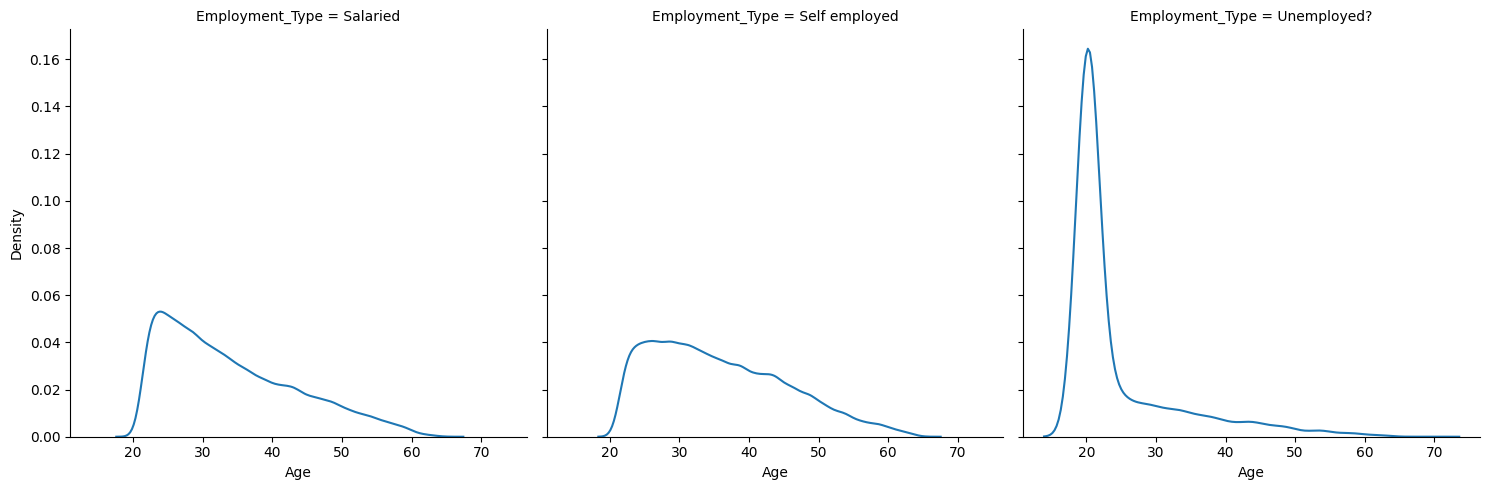

In [24]:
sns.displot(data=df.fillna("Unemployed?"), x='Age', kind='kde', col='Employment_Type', common_norm=False);

After examining relationship of 'Age' to 'Employment_Type' we know there is a high number of young people in NaNs, considerably higher than in other groups. Therefore, NaNs will be filled with 'Unemployed' value.

In [25]:
# Fill NaNs with 'Unemployed'
df['Employment_Type'] = df['Employment_Type'].fillna('Unemployed').astype('category')

Record with category 'Not Scored: More than 50 active Accounts found' for column 'PERFORM_CNS_SCORE_DESCRIPTION' will be deleted (only one value for that category).

In [26]:
# Remove rows where 'PERFORM_CNS.SCORE.DESCRIPTION' is 'Not Scored: More than 50 active Accounts found'
df = df[df['PERFORM_CNS_SCORE_DESCRIPTION'] != 'Not Scored: More than 50 active Accounts found']
df['PERFORM_CNS_SCORE_DESCRIPTION'] = df['PERFORM_CNS_SCORE_DESCRIPTION'].cat.remove_categories('Not Scored: More than 50 active Accounts found')

Next task that'll be performed is to analyse 'PERFORM_CNS_SCORE' using 'PERFORM_CNS_SCORE_DESCRIPTION' feature.

In [27]:
# Compute and display descriptive statistics of 'PERFORM_CNS_SCORE' 
# for each unique value in 'PERFORM_CNS_SCORE_DESCRIPTION'
result_df = pd.DataFrame()

for group_name, group_idx in df.groupby(by='PERFORM_CNS_SCORE_DESCRIPTION').groups.items():
    descriptives_for_group = pd.DataFrame(df.loc[group_idx, :]['PERFORM_CNS_SCORE'].describe())
    descriptives_for_group.columns = [group_name]
    result_df = pd.concat([result_df, descriptives_for_group], axis=1) 

result_df

,A-Very Low Risk,B-Very Low Risk,C-Very Low Risk,D-Very Low Risk,E-Low Risk,F-Low Risk,G-Low Risk,H-Medium Risk,I-Medium Risk,J-High Risk,K-High Risk,L-Very High Risk,M-Very High Risk,No Bureau History Available,Not Scored: No Activity seen on the customer (Inactive),Not Scored: No Updates available in last 36 months,Not Scored: Not Enough Info available on the customer,Not Scored: Only a Guarantor,Not Scored: Sufficient History Not Available
count,12698.000000,8291.000000,14455.000000,10185.000000,5269.000000,7681.000000,3582.000000,6181.000000,5010.000000,3369.000000,7404.000000,1021.000000,7918.0,105225.0,2598.0,1361.0,3309.0,883.0,3395.0
mean,827.679162,774.143891,741.891733,715.959548,691.495350,666.026038,640.836683,616.980262,586.813373,549.868210,440.741086,326.401567,300.0,0.0,16.0,18.0,17.0,14.0,15.0
std,8.870765,11.800827,6.771496,8.835725,7.690298,10.140515,5.527961,8.322714,9.410351,14.372375,45.123854,15.236545,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,806.000000,761.000000,736.000000,706.000000,681.000000,651.000000,631.000000,601.000000,571.000000,521.000000,351.000000,301.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
25%,825.000000,763.000000,738.000000,708.000000,684.000000,657.000000,636.000000,610.000000,579.000000,539.000000,405.000000,311.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
50%,825.000000,771.000000,738.000000,712.000000,692.000000,666.000000,640.000000,616.000000,587.000000,551.000000,441.000000,327.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
75%,832.000000,783.000000,745.000000,725.000000,698.000000,677.000000,646.000000,624.000000,596.000000,563.000000,477.000000,340.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0
max,890.000000,805.000000,760.000000,735.000000,705.000000,680.000000,650.000000,630.000000,600.000000,570.000000,520.000000,350.000000,300.0,0.0,16.0,18.0,17.0,14.0,15.0


Categories from A to L are nicely cut, however there is a problem with columns beginning with 'Not Scored', because their values for 'PERFORM_CNS_SCORE' are encoded as 16, 18, 17, 14 & 15 respectively. They will be replaced with 0.

In [28]:
# Replacing values for 'PERFORM_CNS_SCORE' lower than 300 with 0
df.loc[df['PERFORM_CNS_SCORE'] < 300, 'PERFORM_CNS_SCORE'] = 0

# Other columns

In [29]:
df['DisbursalDate'].dt.year.value_counts()

2018    209835
Name: DisbursalDate, dtype: int64

All disbursal dates are from year 2018.

# Feature engineering

### Numerical features

Bunch of derived column will be created and most of them will represent ratios between two features.

In [30]:
credit_history_length_months = df['CREDIT_HISTORY_LENGTH'].apply(lambda x: pd.DateOffset(months=x))
date_of_first_loan = pd.Timestamp(2019, 1, 1) - credit_history_length_months

df['Age_First_Loan'] = ((date_of_first_loan - df['Date_of_Birth']) / np.timedelta64(1, 'Y'))

# Combine primary and secondary columns into totals
tot_cols = [f'TOT_{c.split("PRI_")[1]}' for c in pri_cols]
df[tot_cols] = df[pri_cols].values + df[sec_cols].values

# Adding 1e-4 to avoid dividing by zero
df['PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['PRI_OVERDUE_ACCTS'] / (1e-4 + df['PRI_ACTIVE_ACCTS'])
df['SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['SEC_OVERDUE_ACCTS'] / (1e-4 + df['SEC_ACTIVE_ACCTS'])
df['TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO'] = df['TOT_OVERDUE_ACCTS'] / (1e-4 + df['TOT_ACTIVE_ACCTS'])

df['PRI_ACTIVE_ACCTS_RATIO'] = df['PRI_ACTIVE_ACCTS'] / (1e-4 + df['PRI_NO_OF_ACCTS'])
df['SEC_ACTIVE_ACCTS_RATIO'] = df['SEC_ACTIVE_ACCTS'] / (1e-4 + df['SEC_NO_OF_ACCTS'])
df['TOT_ACTIVE_ACCTS_RATIO'] = df['TOT_ACTIVE_ACCTS'] / (1e-4 + df['TOT_NO_OF_ACCTS'])

df['DELINQUENT_TO_NEW_ACCTS_RATIO'] = df['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] / (1e-4 + df['NEW_ACCTS_IN_LAST_SIX_MONTHS'])
df['DELINQUENT_TO_ALL_ACCTS_RATIO'] = df['DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS'] / (1e-4 + df['TOT_NO_OF_ACCTS'])

df['PERFORM_CNS_SCORE_NORMALIZED_BY_ltv'] = minmax_scale(df['PERFORM_CNS_SCORE']) * (100 - df['ltv'])

new_derived_numerical = ['Age_First_Loan'] + tot_cols + [   
    'PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
    'SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
    'TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO',

    'PRI_ACTIVE_ACCTS_RATIO',
    'SEC_ACTIVE_ACCTS_RATIO',
    'TOT_ACTIVE_ACCTS_RATIO',

    'DELINQUENT_TO_NEW_ACCTS_RATIO',
    'DELINQUENT_TO_ALL_ACCTS_RATIO',

    'PERFORM_CNS_SCORE_NORMALIZED_BY_ltv',
]
derived_numerical.extend(new_derived_numerical)
numerical.extend(derived_numerical)

pri_cols.extend(['PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'PRI_ACTIVE_ACCTS_RATIO'])
sec_cols.extend(['SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'SEC_ACTIVE_ACCTS_RATIO'])
tot_cols.extend(['TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO', 'TOT_ACTIVE_ACCTS_RATIO'])

# Every TOT column will be of same data type as its respective PRI column
df = df.astype(
    {tot_col: df[pri_col].dtypes.str for tot_col, pri_col in zip(tot_cols, pri_cols)}
)

del new_derived_numerical

Derived numerical columns



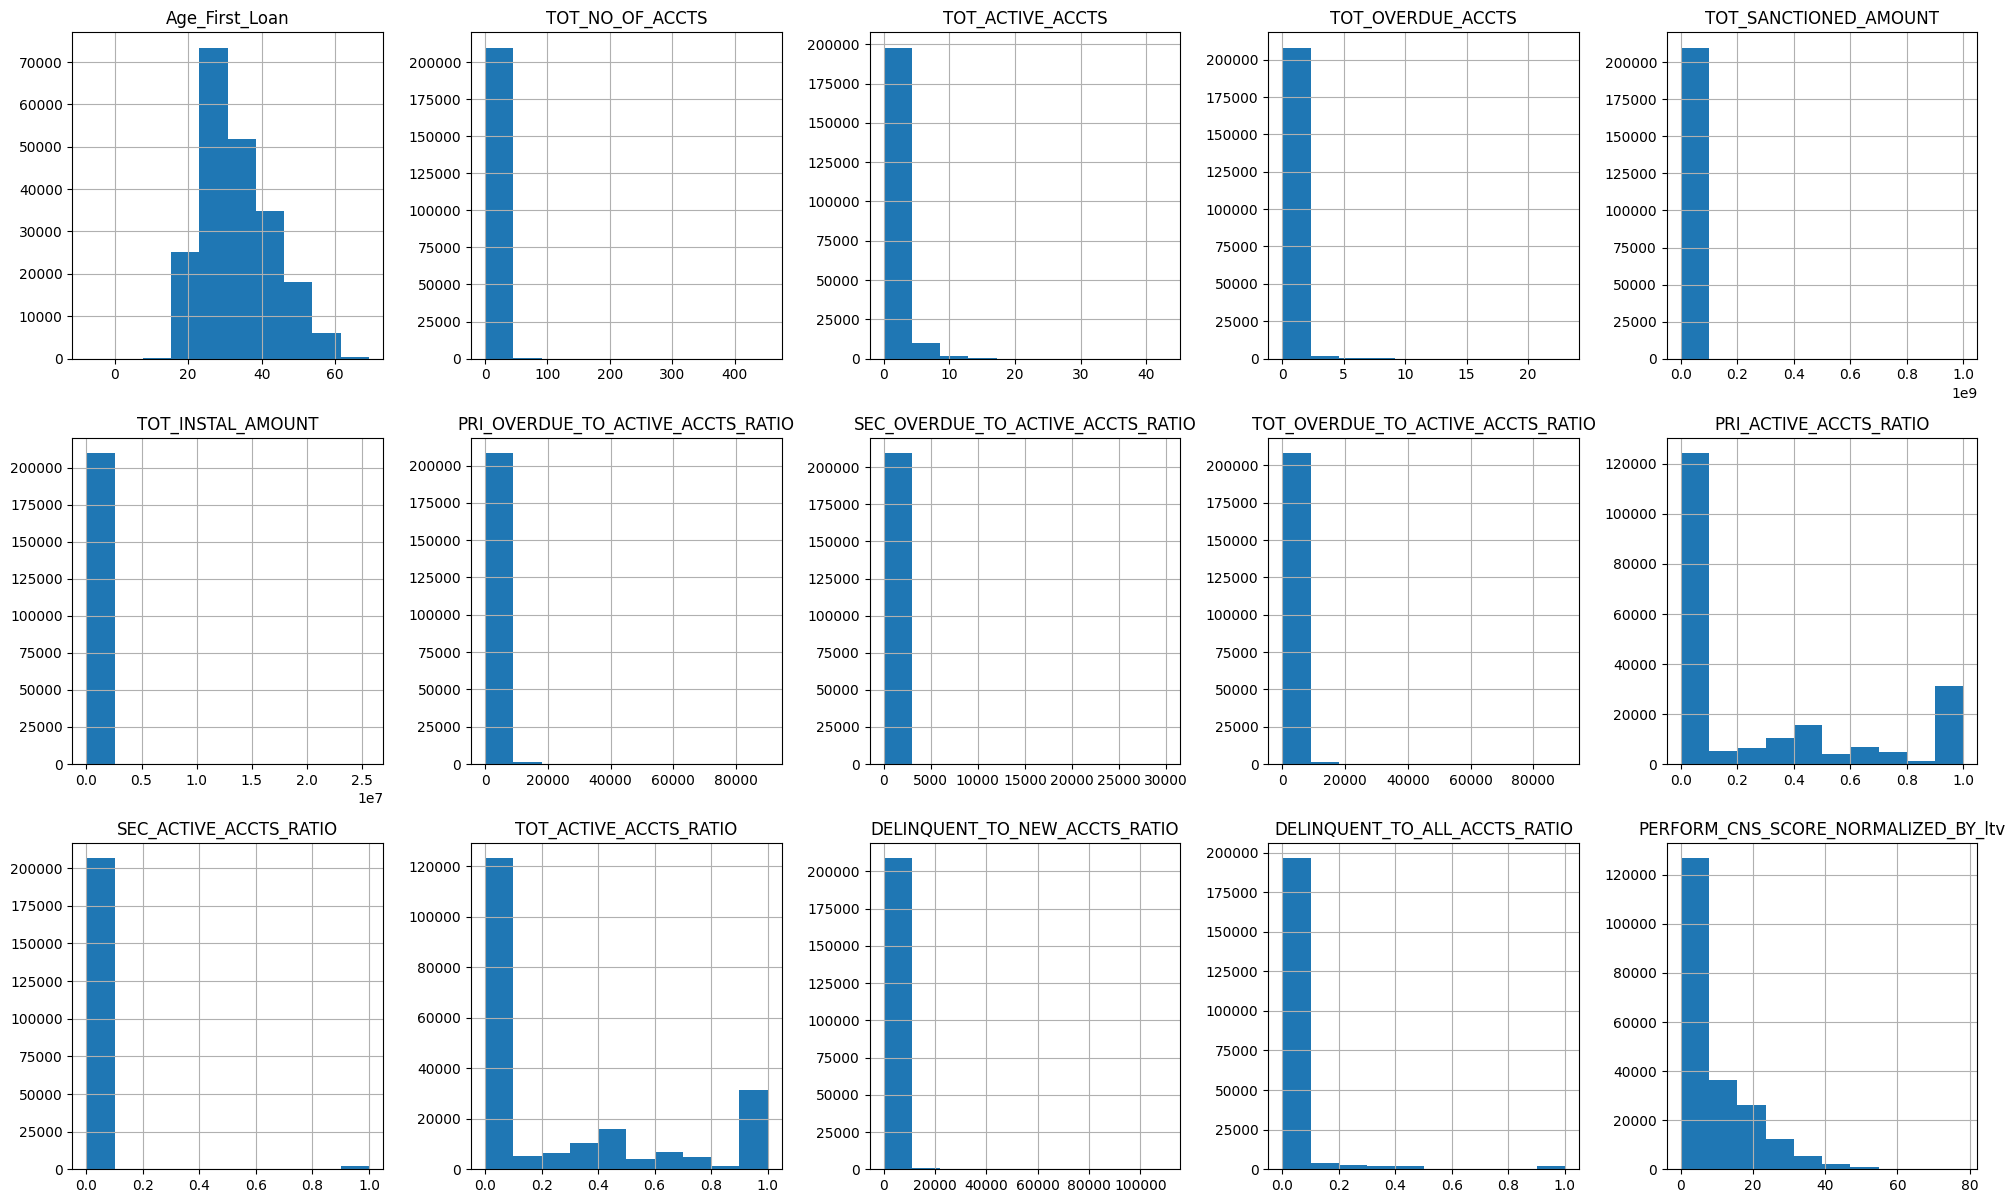

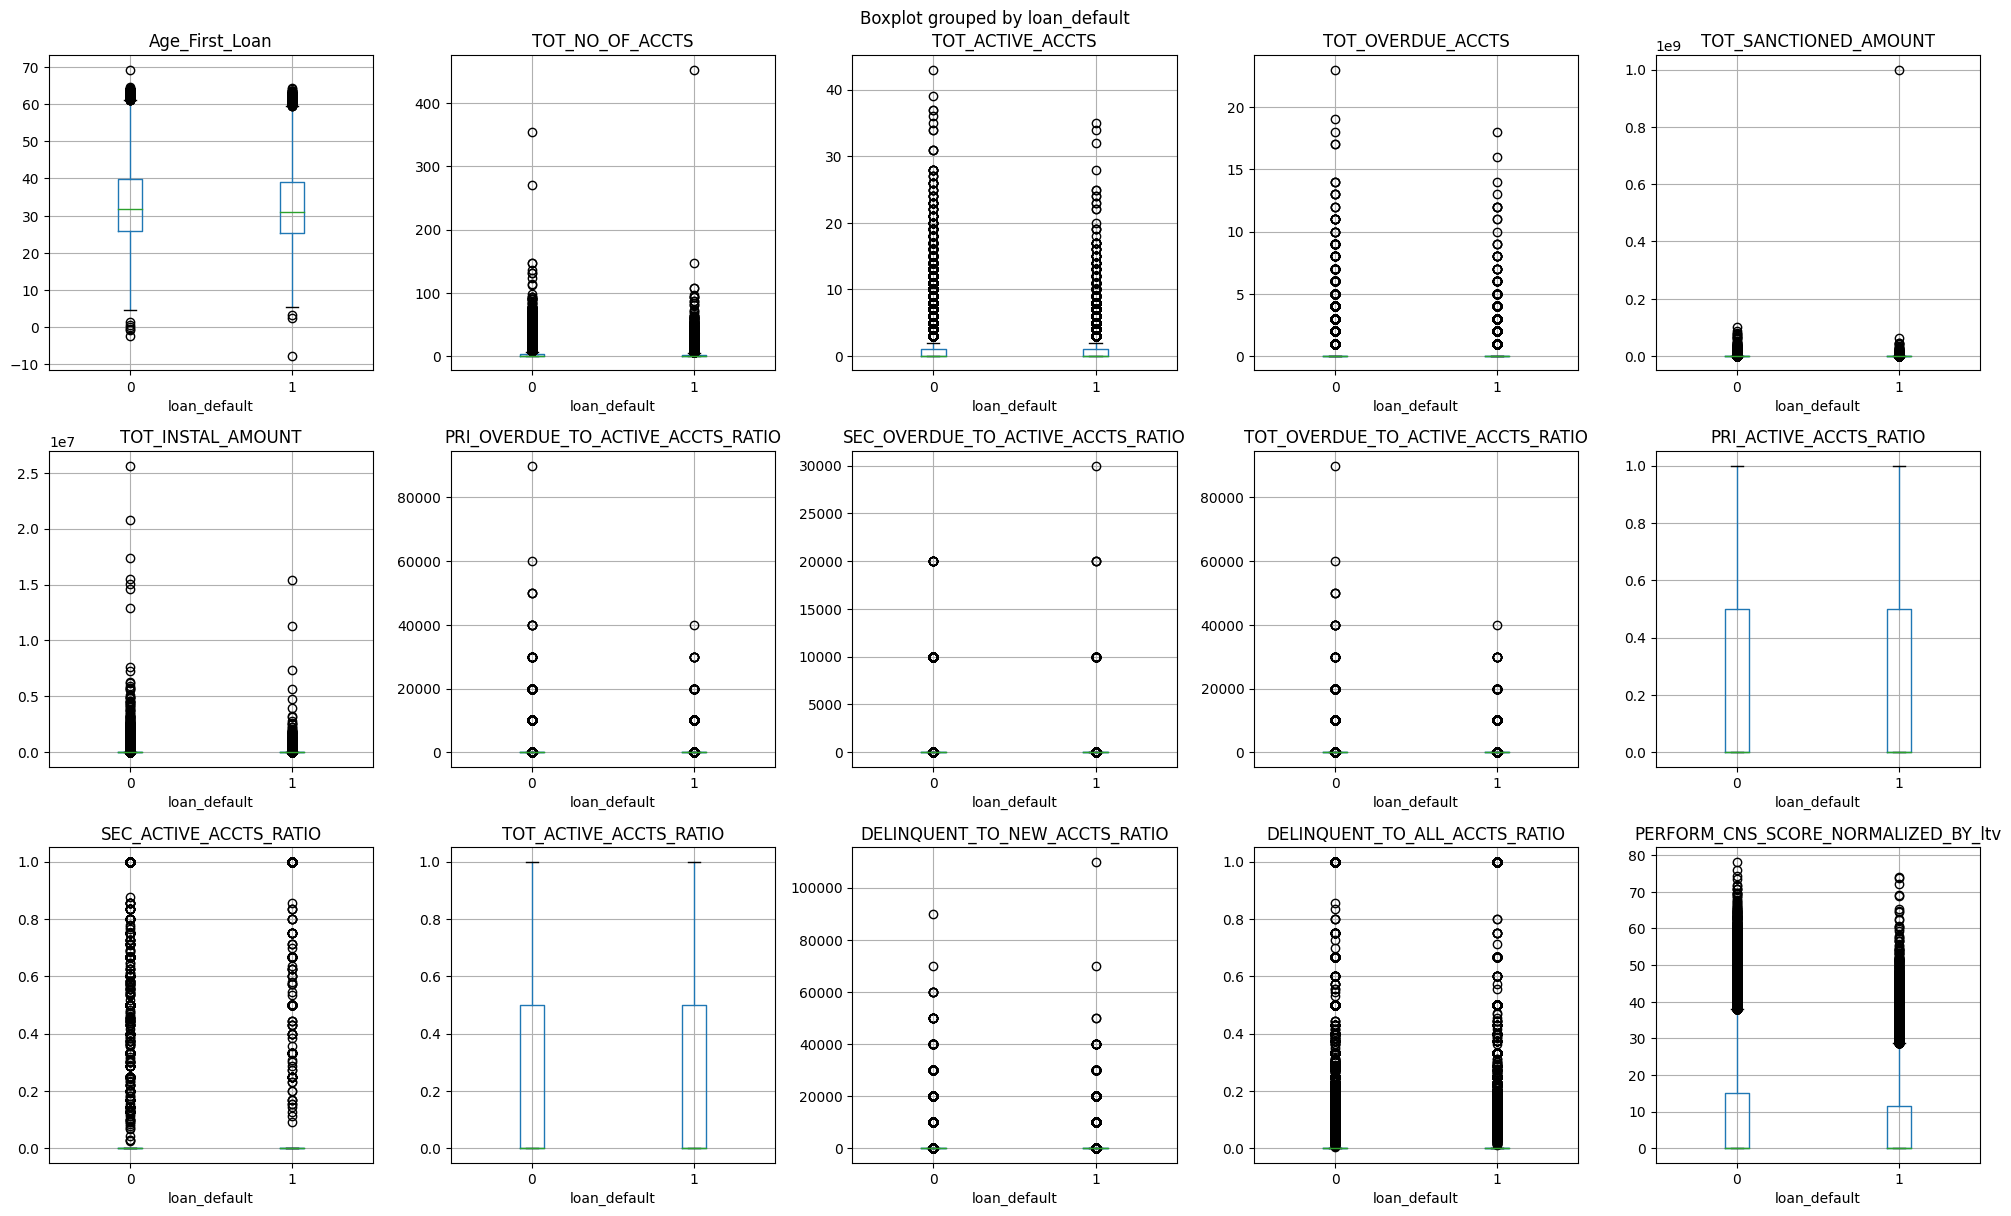

,Age_First_Loan,TOT_NO_OF_ACCTS,TOT_ACTIVE_ACCTS,TOT_OVERDUE_ACCTS,TOT_SANCTIONED_AMOUNT,TOT_INSTAL_AMOUNT,PRI_OVERDUE_TO_ACTIVE_ACCTS_RATIO,SEC_OVERDUE_TO_ACTIVE_ACCTS_RATIO,TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO,PRI_ACTIVE_ACCTS_RATIO,SEC_ACTIVE_ACCTS_RATIO,TOT_ACTIVE_ACCTS_RATIO,DELINQUENT_TO_NEW_ACCTS_RATIO,DELINQUENT_TO_ALL_ACCTS_RATIO,PERFORM_CNS_SCORE_NORMALIZED_BY_ltv
count,209835.000000,209835.000000,209835.000000,209835.000000,2.098350e+05,2.098350e+05,209835.000000,209835.000000,209835.000000,209835.000000,209835.000000,209835.000000,209835.000000,209835.000000,209835.000000
mean,33.397169,2.495394,1.066981,0.163400,2.247859e+05,1.352908e+04,85.136729,12.918737,87.092591,0.268894,0.013234,0.271612,475.979997,0.027017,7.817362
std,9.433604,5.271482,1.951876,0.560623,2.459544e+06,1.562641e+05,1086.661759,381.032942,1101.535319,0.374987,0.108286,0.375096,2555.707602,0.125851,10.814131
min,-7.761966,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.734957,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.499620,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,39.751672,3.000000,1.000000,0.000000,6.600000e+04,2.084000e+03,0.000000,0.000000,0.000000,0.499988,0.000000,0.499988,0.000000,0.000000,14.277809
max,69.296426,453.000000,43.000000,23.000000,1.000000e+09,2.564281e+07,90000.000000,30000.000000,90000.000000,0.999994,0.999992,0.999994,110000.000000,0.999975,78.254494


In [31]:
print("Derived numerical columns")
print()

# Display histograms
df.hist(column=derived_numerical, figsize=(20, 20), layout=(5, 5))
plt.tight_layout()
plt.show();

# Display boxplots
df.boxplot(column=derived_numerical, figsize=(20, 20), by=LABEL, layout=(5,5), sharey=False, sharex=False)
plt.tight_layout()
plt.show();

df[derived_numerical].describe()

From descriptive statistics table we see column 'Age_First_Loan' has minimal value of -7 and notable number of "outliers" (deducted from the boxplot). Let's see how many persons there are who are less than 16.

Number of people with invalid 'Age_First_Loan' (age less than 16): 341


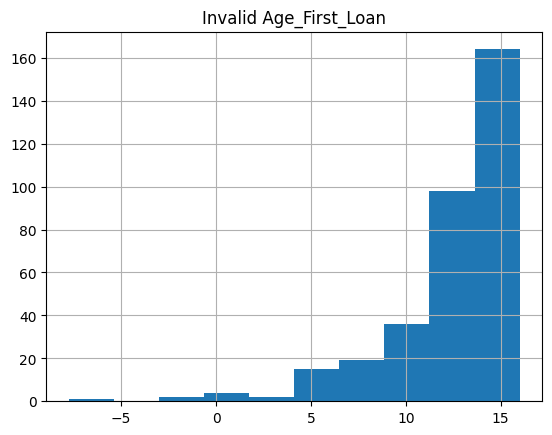

In [32]:
n_people_invalid_age_first_loan = (df['Age_First_Loan'] < 16).sum()
print(f"Number of people with invalid 'Age_First_Loan' (age less than 16): {n_people_invalid_age_first_loan}")

df.loc[df['Age_First_Loan'] < 16, 'Age_First_Loan'].hist()
plt.title("Invalid Age_First_Loan");

A new binary feature 'Invalid_Age_First_Loan' will be created, where 1s will be people who had their loan before age 16 and 0s others.

In [33]:
# Handling records who have 'Age_First_Loan' less than 16
df['Invalid_Age_First_Loan'] = (df['Age_First_Loan'] < 16).astype('uint8')

derived_ordinal.append('Invalid_Age_First_Loan')
ordinal.append('Invalid_Age_First_Loan')

It's wise to see correlations again with the newly derived features.

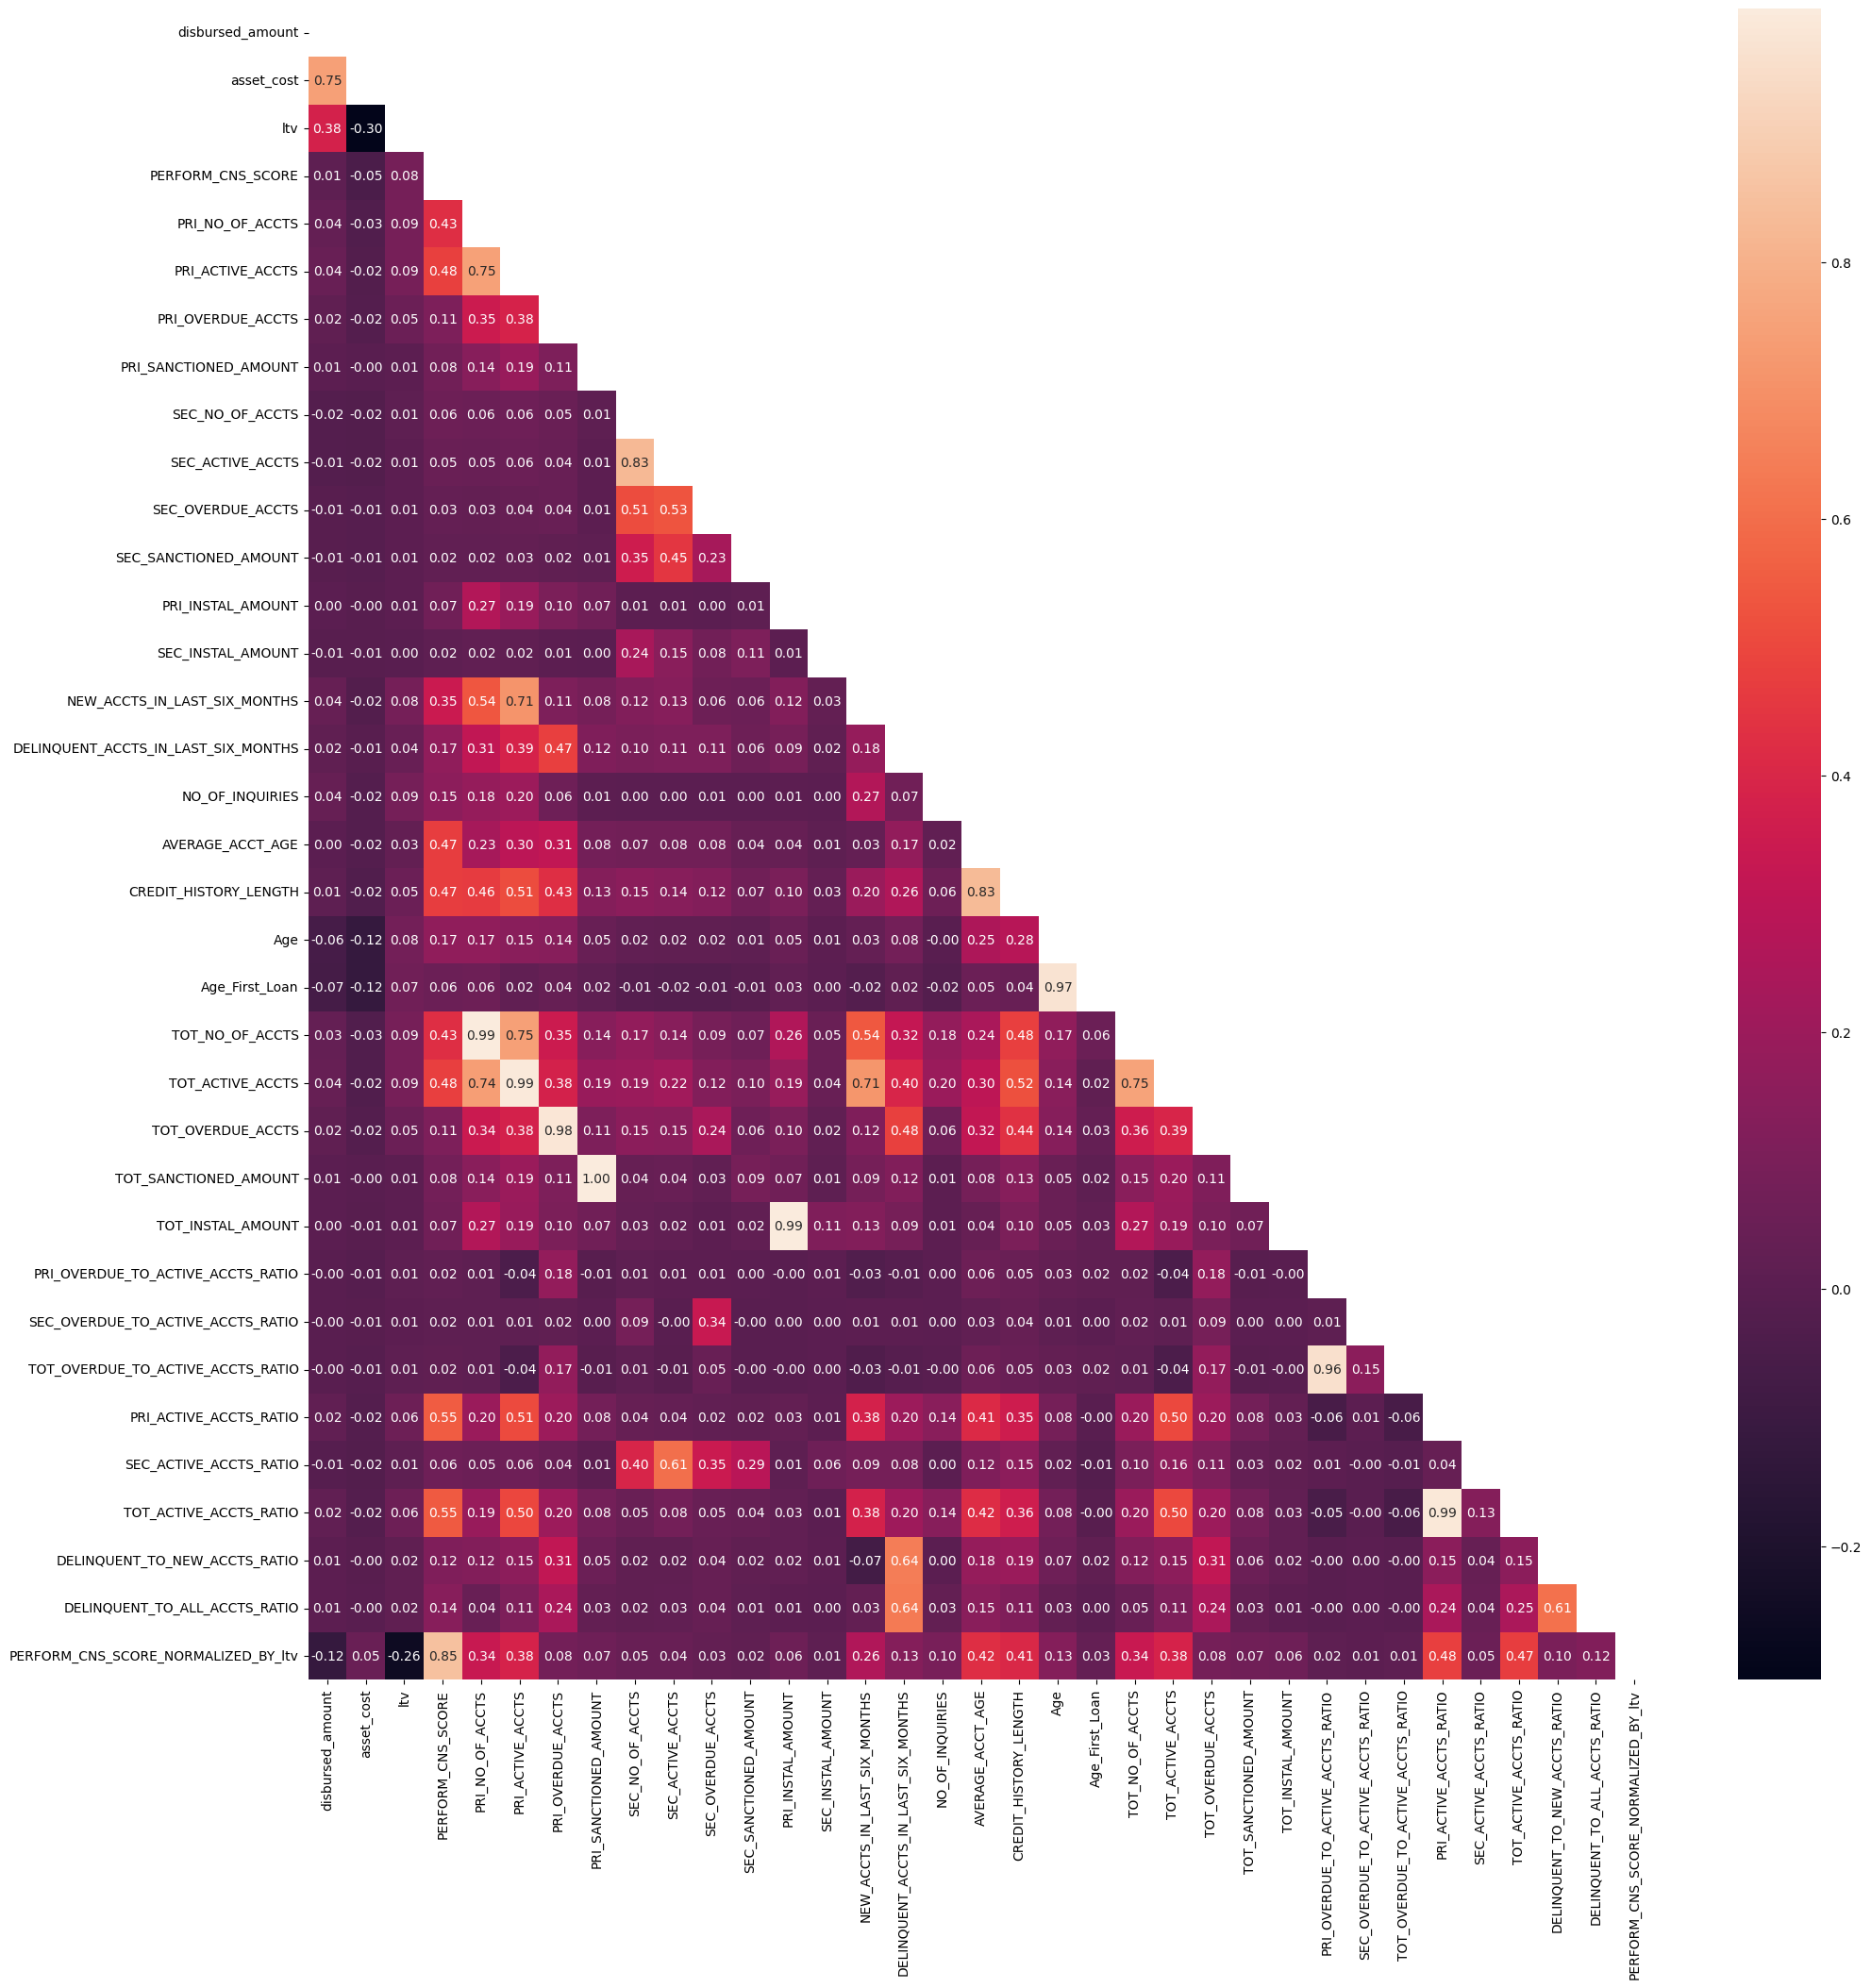

In [34]:
plt.figure(figsize=(23, 23))

corr = df[numerical].corr()

# Upper triangular heatmap of correlations with annotations
sns.heatmap(corr, annot=True, mask=np.triu(corr), fmt='.2f');

All TOT cols have almost 1.00 Pearsons correlation. To determine what columns will be kept, f_classif from sklearn will be applied for PRI & TOT cols. The columns with lesser information gain will be dropped.

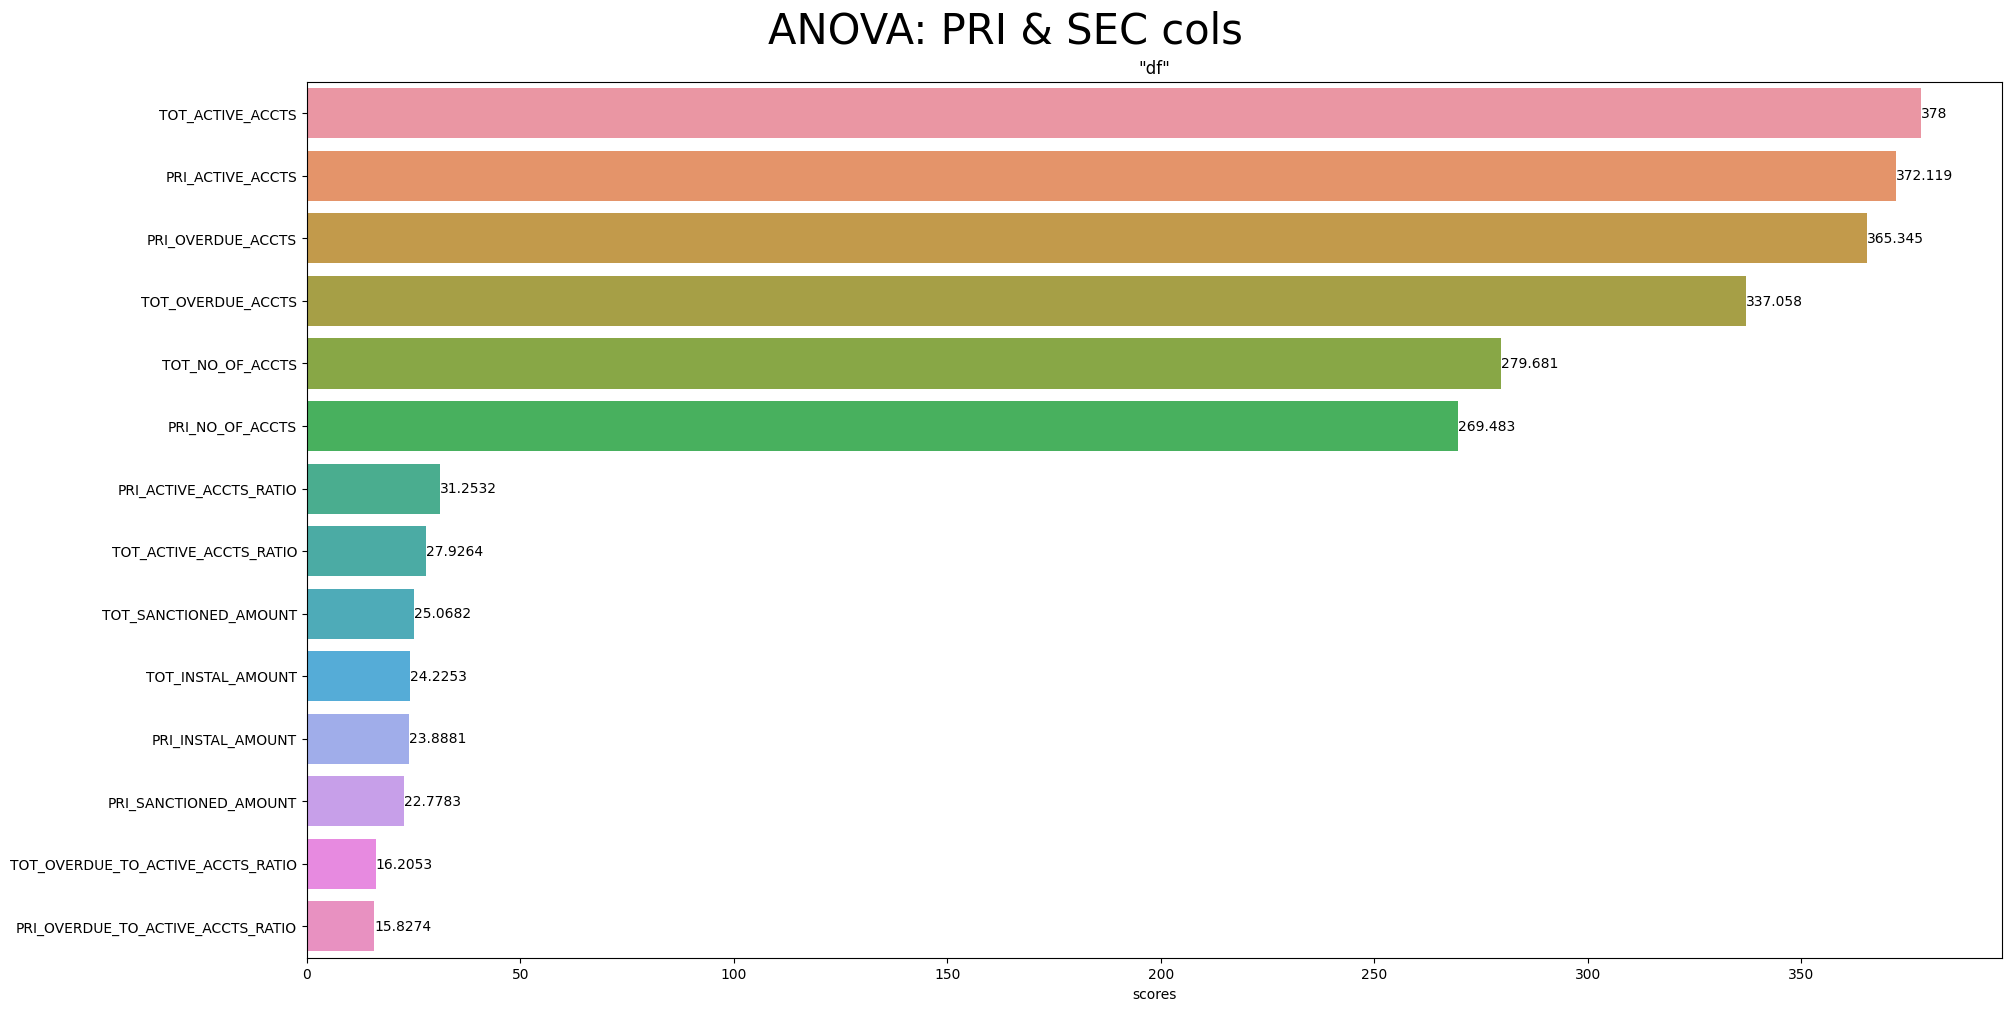

In [35]:
hp.visualize_anova_importance([('df', df)], 'PRI & SEC cols', pri_cols + tot_cols)

Let's see correlations between 'Age_First_Loan', 'Age', since they have +0.97 correlation.

Histogram: 'Age_First_Loan' vs 'Age'


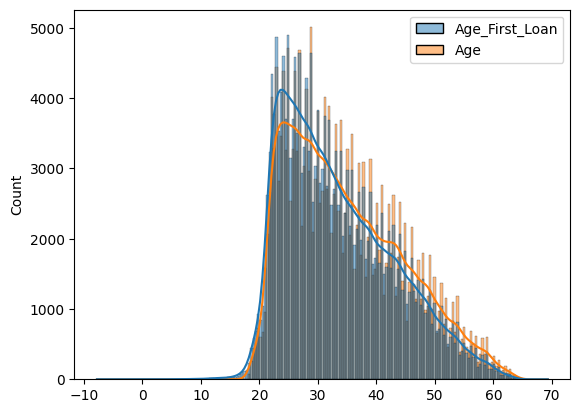

Scatter plot: 'Age_First_Loan' vs 'Age'


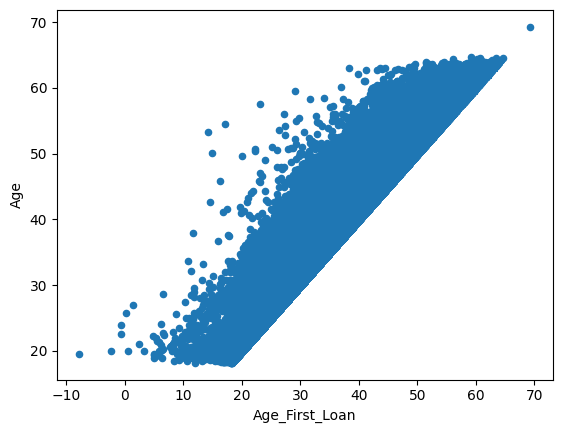

In [36]:
print("Histogram: 'Age_First_Loan' vs 'Age'")
sns.histplot(data=df[['Age_First_Loan', 'Age']], kde=True)
plt.show()

print("Scatter plot: 'Age_First_Loan' vs 'Age'")
df.plot(kind="scatter", x='Age_First_Loan', y='Age')
plt.show()

The columns have almost the same distribution, so 'Age_First_Loan' will be deleted, because column 'CREDIT_HISTORY_LENGTH' is more descriptive.

In [37]:
# Define columns for dropping
to_drop = ['PRI_ACTIVE_ACCTS', 'TOT_OVERDUE_ACCTS', 'PRI_NO_OF_ACCTS', 'TOT_ACTIVE_ACCTS_RATIO',
           'PRI_SANCTIONED_AMOUNT', 'PRI_INSTAL_AMOUNT', 'TOT_OVERDUE_TO_ACTIVE_ACCTS_RATIO',
           'Age_First_Loan']

# Delete cols from df
df = df.drop(to_drop, axis=1)

# Update numerical and derived_numerical list of cols respectively
numerical = [a for a in numerical if a not in to_drop] 
[derived_numerical.remove(a) for a in to_drop if "TOT_" in a]

del to_drop

### Categorical features

The process of engineering new categorical features will be more complicated when we compare it with engineered numerical features: 
<ul>
<li>
'No_Of_Holidays_In_First_Disbursal_Month' will be calculated using holidays library and finding all Indian holidays that will contain period starting from 'DisbursalDate' and one month from it. The intuition is this: if there are a lot of holidays in that period, loanee may struggle to pay monthly amount of loan because he already spent some money preparing for the holidays (food, drinks and other expenses); it's not longer than one month because 'loan_default' describes <i>Payment default in the first EMI on due date</i>, where EMI stands for Equated <b>monthly</b> instalments.</li>
<li>'Month_of_Birth' is calculated using loanee's 'Date_of_Birth'</li>
<li>'shared_documents' is calculated by adding all flag categories</li>
</ul>

In [38]:
df['No_Of_Holidays_In_First_Disbursal_Month'] = df['DisbursalDate'].apply(lambda x: hp.calculate_no_of_holidays(x, INDIA_HOLIDAYS)).astype('int8')
df['shared_documents'] = (df['Aadhar_flag'] + df['PAN_flag'] + df['VoterID_flag'] + df['Driving_flag']).astype('uint8')

df['Month_of_Birth'] = df['Date_of_Birth'].dt.month.astype('category')

new_derived_ordinal = ['shared_documents',
                'No_Of_Holidays_In_First_Disbursal_Month'
]
new_derived_nominal = ['Month_of_Birth']

ordinal.extend(new_derived_ordinal)
nominal.extend(new_derived_nominal)

derived_ordinal.extend(new_derived_ordinal)
derived_nominal.extend(new_derived_nominal)

del new_derived_ordinal, new_derived_nominal

In [39]:
# Display value counts for every derived categorical column
for col in derived_ordinal + derived_nominal:
    print(f"Column: {col}")
    c = df[col].value_counts(dropna=False)
    p = df[col].value_counts(dropna=False, normalize=True) * 100

    display(pd.concat([c, p], axis=1, keys=['counts', '%']))
    print()

Column: Invalid_Age_First_Loan


,counts,%
0,209494,99.837491
1,341,0.162509



Column: shared_documents


,counts,%
1,191819,91.414206
2,17404,8.294136
0,328,0.156313
3,281,0.133915
4,3,0.001430



Column: No_Of_Holidays_In_First_Disbursal_Month


,counts,%
2,99769,47.546406
1,81868,39.015417
3,19668,9.373079
0,8530,4.065099



Column: Month_of_Birth


,counts,%
1,62141,29.614221
6,21303,10.152262
5,16418,7.824243
7,15036,7.165630
10,13444,6.406939
4,13123,6.253961
3,13061,6.224414
8,12788,6.094312
2,12581,5.995663
12,10728,5.112588


Now we are ready for the modelling part.